In [1]:
# Import necessary libraries for comprehensive statistical analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical libraries
import scipy.stats as stats
from scipy.stats import (
    pearsonr, spearmanr, kendalltau,
    shapiro, normaltest, jarque_bera,
    mannwhitneyu, kruskal, chi2_contingency,
    f_oneway, ttest_ind, levene
)

# Machine learning and advanced statistics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split

# Additional statistical tools
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

import warnings
from pathlib import Path

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set publication-ready plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Color scheme for years
year_colors = {
    2021: '#E74C3C',  # Red
    2022: '#3498DB',  # Blue  
    2023: '#2ECC71',  # Green
}

print("✅ Libraries loaded successfully!")
print("📊 Statistical analysis environment configured")
print("🎨 Publication-ready plotting style set")

✅ Libraries loaded successfully!
📊 Statistical analysis environment configured
🎨 Publication-ready plotting style set


## 1. Data Loading and Initial Exploration

In [2]:
# Load cleaned data
data_dir = Path('../data')
cleaned_file = data_dir / '2025_09_02_FC_K_A_cleaned.csv'

# Check if cleaned data exists
if not cleaned_file.exists():
    print(f"❌ Cleaned data file not found at {cleaned_file}")
    print("Please run the data cleaning notebook first.")
else:
    df = pd.read_csv(cleaned_file)
    print(f"✅ Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    print(f"Rows: {len(df)}")
    
    # Create pass/fail indicator if not exists
    if 'passed' not in df.columns and 'final_grade' in df.columns:
        df['passed'] = (df['final_grade'] >= 2).astype(int)
        print("✅ Pass/fail indicator created (grade >= 2)")
    
    # Display basic info about pass/fail distribution
    if 'passed' in df.columns:
        pass_rate = df['passed'].mean() * 100
        print(f"📊 Overall pass rate: {pass_rate:.1f}%")
        print(f"📊 Passed students: {df['passed'].sum()}, Failed students: {(df['passed'] == 0).sum()}")
    
    # Year distribution
    print(f"\n📅 Year distribution:")
    for year in sorted(df['academic_year'].unique()):
        count = len(df[df['academic_year'] == year])
        print(f"  {year}: {count} students ({count/len(df)*100:.1f}%)")

print(f"Features: {df.columns}")

✅ Data loaded successfully!
Shape: (147, 60)
Columns: 60
Rows: 147
📊 Overall pass rate: 55.2%
📊 Passed students: 80.0, Failed students: 65

📅 Year distribution:
  2021: 45 students (30.6%)
  2022: 49 students (33.3%)
  2023: 53 students (36.1%)
Features: Index(['academic_year', 'student_id', 'first_name', 'last_name', 'repeater',
       'test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 'test_p9',
       'test_p10', 'test_p11', 'test_p12', 'test_p13', 'num_tests_taken',
       'avg_success_rate_per_test', 'percentage_points', 'fc_total_points',
       'team', 'presentation_points', 'defense_points', 'total_defense_points',
       'exam_k2', 'exam_k3', 'exam_k2_k3_total', 'total_continuous',
       'final_grade', 'survey_q1', 'survey_q2', 'survey_q3', 'survey_q4',
       'survey_q5', 'survey_q6', 'survey_q7', 'survey_q8', 'survey_q9',
       'survey_q10', 'survey_q11', 'survey_q12', 'survey_q13', 'survey_q14',
       'survey_q15', 'survey_q16', 'survey_q17', 'survey_q18', 'survey_q1

In [3]:
# Define test variables and create engagement metrics
test_variables = ['test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 
                 'test_p9', 'test_p10', 'test_p11', 'test_p12', 'test_p13']

print("🧮 Creating Engagement Metrics...")
print("="*50)

# Check which test variables are available
available_tests = [test for test in test_variables if test in df.columns]
missing_tests = [test for test in test_variables if test not in df.columns]

print(f"✅ Available test variables ({len(available_tests)}): {available_tests}")
if missing_tests:
    print(f"⚠️ Missing test variables ({len(missing_tests)}): {missing_tests}")

# Create engagement metrics
if available_tests:
    # 1. Test Participation Rate (proportion of tests attempted)
    df['tests_participation_rate'] = df[available_tests].notna().sum(axis=1) / len(available_tests)
    
    # 2. Test Average Score (mean of attempted tests)
    df['tests_avg_score'] = df[available_tests].mean(axis=1, skipna=True)
    df["tests_avg_score"].fillna(0, inplace=True)
    
    # 3. Tests Attempted (absolute count)
    df['tests_attempted'] = df[available_tests].notna().sum(axis=1)
    df['tests_attempted_check'] = df['tests_attempted'] == df['num_tests_taken']
    
    # 4. Test Total Score (sum of all tests, NaN treated as 0)
    df['tests_total_score'] = df[available_tests].fillna(0).sum(axis=1)
    df['fc_total_points_check'] = df['fc_total_points'] == df['tests_total_score']
    
    # 5. Test Engagement Score (combined metric: participation × performance)
    df['tests_engagement_score'] = df['tests_participation_rate'] * df['tests_avg_score'].fillna(0)
    
    # 6. Consistency Score (inverse of coefficient of variation)
    test_std = df[available_tests].std(axis=1, skipna=True, ddof=0)  # Use population std
    test_mean = df[available_tests].mean(axis=1, skipna=True)
    
    # Handle cases where mean is zero or very small
    valid_mean_mask = (test_mean > 0.01)  # Only calculate CV for meaningful means
    cv = np.where(valid_mean_mask, test_std / test_mean, np.nan)
    
    test_scores_std = df[available_tests].std(axis=1, skipna=True, ddof=0)
    max_std = test_scores_std.max() if not test_scores_std.isna().all() else 1
    df['tests_consistency'] = 1 - (test_scores_std.fillna(max_std) / max_std)
    
    test_variance = df[available_tests].var(axis=1, skipna=True, ddof=0)
    max_variance = test_variance.max() if not test_variance.isna().all() else 1
    
    # Normalize variance to 0-1 scale, then invert (higher = more stable)
    df['tests_consistency_stability'] = 1 - (test_variance.fillna(max_variance) / max_variance)
    
    mid_point = len(available_tests) // 2
    first_half = available_tests[:mid_point]
    second_half = available_tests[mid_point:]
    
    first_half_mean = df[first_half].mean(axis=1, skipna=True)
    second_half_mean = df[second_half].mean(axis=1, skipna=True)
    
    # Calculate normalized absolute difference
    performance_drift = abs(first_half_mean - second_half_mean)
    max_drift = performance_drift.max() if not performance_drift.isna().all() else 1
    
    # Convert to consistency score (0-1 scale, higher = more consistent)
    df['tests_early_late_consistency'] = 1 - (performance_drift.fillna(max_drift) / max_drift)
    
    # --- Add percentile features for key engagement metrics ---
    print("\n📊 Calculating Percentiles for Engagement Metrics...")
    
    # Ensure required columns exist
    percentile_metrics = [
        'tests_participation_rate', 
        'tests_attempted',
        'tests_avg_score', 
        'tests_total_score', 
        'tests_engagement_score',
        'tests_consistency',
        'tests_consistency_stability',
        'tests_early_late_consistency',
    ]
    
    for metric in percentile_metrics:
        if metric in df.columns:
            percentile_col = f"{metric}_perct"
            df[percentile_col] = df[metric].rank(pct=True) * 100  # Percentile from 0-100
            print(f"  • {percentile_col} created (mean={df[percentile_col].mean():.2f}, "
                  f"min={df[percentile_col].min():.2f}, max={df[percentile_col].max():.2f})")
        else:
            print(f"  ⚠️ Skipping {metric}, column not found")
            
    print("\n✅ Engagement metrics created:")
    engagement_metrics = percentile_metrics + [
        f"{metric}_perct" for metric in percentile_metrics
    ]
                            
    for metric in engagement_metrics:
        if metric in df.columns:
            print(f"  • {metric}: mean={df[metric].mean():.3f}, std={df[metric].std():.3f}")
else:
    print("❌ No test variables available for analysis")

print(df.columns)
# Define achievement metrics
achievement_metrics = []
if 'final_grade' in df.columns:
    achievement_metrics.append('final_grade')
if 'passed' in df.columns:
    achievement_metrics.append('passed')

print(f"\n🎯 Achievement metrics available: {achievement_metrics}")


df["final_grade"].fillna(1.0, inplace=True)
df["passed"].fillna(0.0, inplace=True)

df[test_variables + engagement_metrics + achievement_metrics + ['final_grade', 'passed']]

🧮 Creating Engagement Metrics...
✅ Available test variables (10): ['test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 'test_p9', 'test_p10', 'test_p11', 'test_p12', 'test_p13']

📊 Calculating Percentiles for Engagement Metrics...
  • tests_participation_rate_perct created (mean=50.34, min=1.36, max=82.99)
  • tests_attempted_perct created (mean=50.34, min=1.36, max=82.99)
  • tests_avg_score_perct created (mean=50.34, min=2.04, max=100.00)
  • tests_total_score_perct created (mean=50.34, min=2.04, max=100.00)
  • tests_engagement_score_perct created (mean=50.34, min=2.04, max=100.00)
  • tests_consistency_perct created (mean=50.34, min=1.70, max=98.98)
  • tests_consistency_stability_perct created (mean=50.34, min=1.70, max=98.98)
  • tests_early_late_consistency_perct created (mean=50.34, min=6.80, max=97.96)

✅ Engagement metrics created:
  • tests_participation_rate: mean=0.778, std=0.262
  • tests_attempted: mean=7.776, std=2.622
  • tests_avg_score: mean=0.575, std=0.230
  • t

,test_p4,test_p5,test_p6,test_p7,test_p8,test_p9,test_p10,test_p11,test_p12,test_p13,tests_participation_rate,tests_attempted,tests_avg_score,tests_total_score,tests_engagement_score,tests_consistency,tests_consistency_stability,tests_early_late_consistency,tests_participation_rate_perct,tests_attempted_perct,tests_avg_score_perct,tests_total_score_perct,tests_engagement_score_perct,tests_consistency_perct,tests_consistency_stability_perct,tests_early_late_consistency_perct,final_grade,passed,final_grade,passed
0,1.00,NaN,0.33,0.00,0.00,0.67,1.00,NaN,0.33,0.00,0.8,8,0.416250,3.33,0.333,0.052288,0.101841,0.750000,40.476190,40.476190,26.530612,32.653061,32.653061,4.761905,4.761905,56.802721,4.0,1.0,4.0,1.0
1,1.00,NaN,0.00,0.33,0.00,0.00,NaN,NaN,0.33,NaN,0.6,6,0.276667,1.66,0.166,0.157774,0.290655,0.750000,20.068027,20.068027,11.224490,13.605442,13.605442,12.925170,12.925170,56.802721,1.0,0.0,1.0,0.0
2,0.33,0.67,0.33,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.9,9,0.147778,1.33,0.133,0.458602,0.706888,0.602985,57.482993,57.482993,4.761905,11.904762,11.904762,66.326531,66.326531,38.435374,3.0,1.0,3.0,1.0
3,0.33,0.33,0.33,0.00,NaN,0.33,NaN,NaN,NaN,NaN,0.5,5,0.264000,1.32,0.132,0.687327,0.902235,0.876866,15.646259,15.646259,8.843537,10.884354,10.884354,97.278912,97.278912,76.870748,1.0,0.0,1.0,0.0
4,1.00,0.00,1.00,0.67,0.33,0.67,1.00,0.00,0.67,1.00,1.0,10,0.634000,6.34,0.634,0.102364,0.194250,0.898507,82.993197,82.993197,54.421769,66.666667,66.666667,8.163265,8.163265,81.292517,3.0,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,1.00,1.00,1.00,1.00,0.00,1.00,0.67,1.00,1.00,0.67,1.0,10,0.834000,8.34,0.834,0.272894,0.471317,0.898507,82.993197,82.993197,85.034014,91.156463,91.156463,33.673469,33.673469,81.292517,4.0,1.0,4.0,1.0
143,1.00,0.67,0.67,0.33,0.67,0.67,0.67,0.67,0.67,0.67,1.0,10,0.669000,6.69,0.669,0.645092,0.874041,0.997015,82.993197,82.993197,63.265306,74.829932,74.829932,95.918367,95.918367,92.176871,1.0,0.0,1.0,0.0
144,0.33,1.00,NaN,NaN,0.00,0.00,0.33,NaN,0.00,NaN,0.6,6,0.276667,1.66,0.166,0.157774,0.290655,0.502488,20.068027,20.068027,11.224490,13.605442,13.605442,12.244898,12.244898,25.850340,1.0,0.0,1.0,0.0
145,0.00,0.67,0.33,0.67,1.00,0.00,0.67,0.67,0.67,1.00,1.0,10,0.568000,5.68,0.568,0.204739,0.367560,0.898507,82.993197,82.993197,44.557823,59.183673,59.183673,19.047619,19.047619,77.891156,1.0,0.0,1.0,0.0


## 2. Distribution Analysis and Statistical Method Selection

Before applying statistical tests, we need to understand the distributions of our variables to select appropriate methods.

['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']

📊 Engagement Metrics Distribution Analysis

📊 tests_participation_rate:
  Sample size: 147
  Mean ± SD: 0.778 ± 0.262
  Median: 0.900
  Skewness: -1.324 (Highly skewed)
  Kurtosis: 0.894 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)

📊 tests_attempted:
  Sample size: 147
  Mean ± SD: 7.776 ± 2.622
  Median: 9.000
  Skewness: -1.324 (Highly skewed)

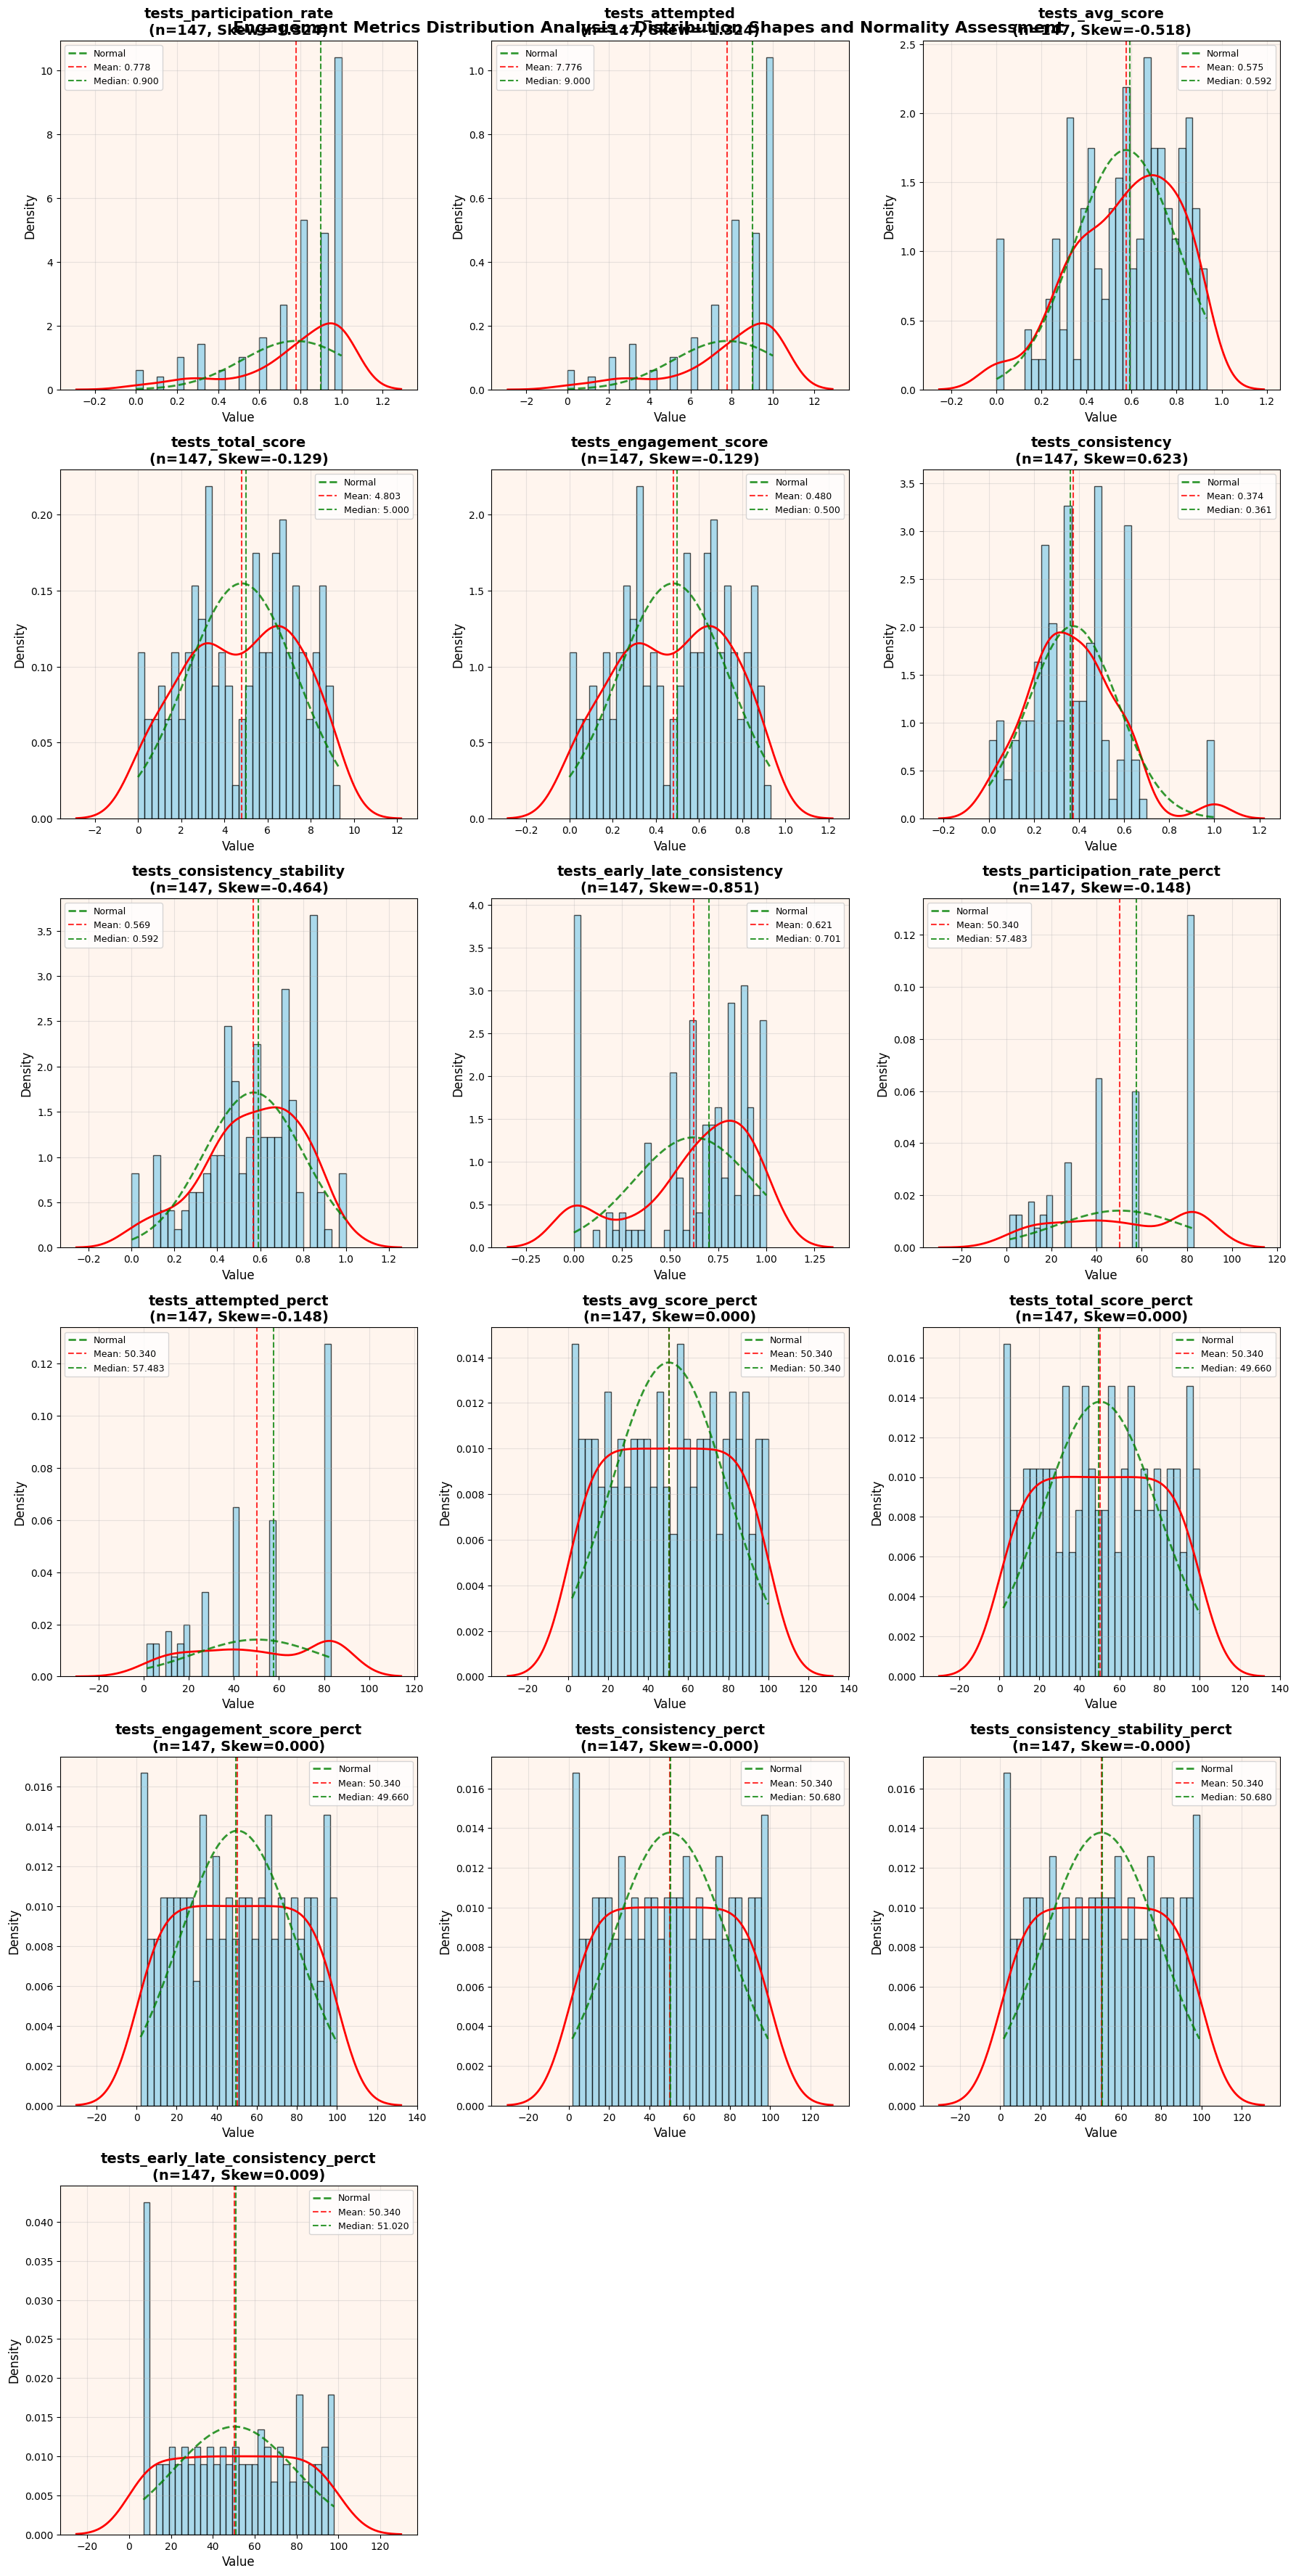


📋 SUMMARY TABLE:
                          Variable   N   Mean    Std  Skewness  Is_Normal Recommended_Method
          tests_participation_rate 147  0.778  0.262    -1.324      False     Non-parametric
                   tests_attempted 147  7.776  2.622    -1.324      False     Non-parametric
                   tests_avg_score 147  0.575  0.230    -0.518      False     Non-parametric
                 tests_total_score 147  4.803  2.578    -0.129      False     Non-parametric
            tests_engagement_score 147  0.480  0.258    -0.129      False     Non-parametric
                 tests_consistency 147  0.374  0.199     0.623      False     Non-parametric
       tests_consistency_stability 147  0.569  0.233    -0.464      False     Non-parametric
      tests_early_late_consistency 147  0.621  0.311    -0.851      False     Non-parametric
    tests_participation_rate_perct 147 50.340 28.193    -0.148      False     Non-parametric
             tests_attempted_perct 147 50.340 28.193

In [4]:
def comprehensive_distribution_analysis(data, variables, title="Distribution Analysis"):
    """
    Comprehensive distribution analysis with multiple normality tests
    and recommendations for statistical methods
    """
    print(f"\n{'='*80}")
    print(f"📊 {title}")
    print(f"{'='*80}")
    
    results = []
    
    # Create subplots for visualizations
    n_vars = len(variables)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        if var not in data.columns:
            print(f"⚠️ Variable {var} not found in dataset")
            continue
            
        var_data = data[var].dropna()
        
        if len(var_data) < 3:
            print(f"⚠️ Insufficient data for {var} (n={len(var_data)})")
            continue
        
        # Basic statistics
        mean_val = var_data.mean()
        median_val = var_data.median()
        std_val = var_data.std()
        skewness = stats.skew(var_data)
        kurtosis = stats.kurtosis(var_data)
        
        # Normality tests
        normality_results = {}
        
        # Shapiro-Wilk (best for n < 5000)
        if len(var_data) <= 5000:
            try:
                shapiro_stat, shapiro_p = shapiro(var_data)
                normality_results['Shapiro-Wilk'] = {'stat': shapiro_stat, 'p': shapiro_p}
            except:
                normality_results['Shapiro-Wilk'] = {'stat': np.nan, 'p': np.nan}
        
        # D'Agostino-Pearson (good for larger samples)
        if len(var_data) >= 8:
            try:
                dagostino_stat, dagostino_p = normaltest(var_data)
                normality_results['D\'Agostino'] = {'stat': dagostino_stat, 'p': dagostino_p}
            except:
                normality_results['D\'Agostino'] = {'stat': np.nan, 'p': np.nan}
        
        # Jarque-Bera test
        if len(var_data) >= 7:
            try:
                jb_stat, jb_p = jarque_bera(var_data)
                normality_results['Jarque-Bera'] = {'stat': jb_stat, 'p': jb_p}
            except:
                normality_results['Jarque-Bera'] = {'stat': np.nan, 'p': np.nan}
        
        # Determine if distribution is normal
        p_values = [result['p'] for result in normality_results.values() if not np.isnan(result['p'])]
        is_normal = len(p_values) > 0 and np.mean(p_values) > 0.05
        
        # Visual analysis
        ax = axes[i]
        
        # Histogram with KDE and normal overlay
        ax.hist(var_data, bins=min(30, len(var_data)//3), density=True, alpha=0.7, 
                color='skyblue', edgecolor='black')
        
        # KDE plot
        if std_val > 0:
            try:
                sns.kdeplot(data=var_data, ax=ax, color='red', linewidth=2)
            except:
                pass
        
        # Normal distribution overlay
        if std_val > 0:
            x_norm = np.linspace(var_data.min(), var_data.max(), 100)
            y_norm = stats.norm.pdf(x_norm, mean_val, std_val)
            ax.plot(x_norm, y_norm, 'g--', linewidth=2, alpha=0.8, label='Normal')
        
        # Add vertical lines for mean and median
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_val:.3f}')
        
        # Formatting
        ax.set_title(f'{var}\n(n={len(var_data)}, Skew={skewness:.3f})', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Color coding for normality
        if is_normal:
            ax.set_facecolor('#f0f8ff')  # Light blue for normal
        else:
            ax.set_facecolor('#fff5ee')  # Light orange for non-normal
        
        # Store results
        result = {
            'Variable': var,
            'N': len(var_data),
            'Mean': mean_val,
            'Median': median_val,
            'Std': std_val,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Is_Normal': is_normal,
            'Recommended_Method': 'Parametric' if is_normal else 'Non-parametric'
        }
        
        # Add normality test results
        for test_name, test_result in normality_results.items():
            result[f'{test_name}_p'] = test_result['p']
        
        results.append(result)
        
        print(f"\n📊 {var}:")
        print(f"  Sample size: {len(var_data)}")
        print(f"  Mean ± SD: {mean_val:.3f} ± {std_val:.3f}")
        print(f"  Median: {median_val:.3f}")
        print(f"  Skewness: {skewness:.3f} ({'Symmetric' if abs(skewness) < 0.5 else 'Moderately skewed' if abs(skewness) < 1 else 'Highly skewed'})")
        print(f"  Kurtosis: {kurtosis:.3f} ({'Normal-like' if abs(kurtosis) < 0.5 else 'Heavy/Light tails'})")
        
        print(f"  Normality Tests:")
        for test_name, test_result in normality_results.items():
            if not np.isnan(test_result['p']):
                significance = "Normal" if test_result['p'] > 0.05 else "Non-normal"
                print(f"    {test_name}: p = {test_result['p']:.4f} ({significance})")
        
        print(f"  🎯 Recommended: {'Parametric tests (t-test, Pearson correlation, ANOVA)' if is_normal else 'Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)'}")
    
    # Remove empty subplots
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(f'{title} - Distribution Shapes and Normality Assessment', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        print(f"\n📋 SUMMARY TABLE:")
        print(f"{'='*80}")
        
        display_cols = ['Variable', 'N', 'Mean', 'Std', 'Skewness', 'Is_Normal', 'Recommended_Method']
        available_cols = [col for col in display_cols if col in results_df.columns]
        
        summary_table = results_df[available_cols].round(3)
        print(summary_table.to_string(index=False))
        
        # Statistical method recommendations
        normal_count = sum(results_df['Is_Normal'])
        total_count = len(results_df)
        
        print(f"\n💡 STATISTICAL METHOD RECOMMENDATIONS:")
        print(f"{'='*60}")
        print(f"Variables with normal distribution: {normal_count}/{total_count} ({normal_count/total_count*100:.1f}%)")
        
        if normal_count >= total_count * 0.8:
            print("🎯 Recommendation: Primarily use PARAMETRIC methods")
            print("  • Pearson correlations")
            print("  • t-tests for group comparisons")
            print("  • ANOVA for multiple groups")
            print("  • Linear regression")
        elif normal_count >= total_count * 0.5:
            print("🎯 Recommendation: Use MIXED approach (both parametric and non-parametric)")
            print("  • Use parametric tests for normal variables")
            print("  • Use non-parametric tests for non-normal variables")
            print("  • Report both Pearson and Spearman correlations")
        else:
            print("🎯 Recommendation: Primarily use NON-PARAMETRIC methods")
            print("  • Spearman correlations")
            print("  • Mann-Whitney U tests for group comparisons")
            print("  • Kruskal-Wallis for multiple groups")
            print("  • Robust regression techniques")
    
    return results_df

print(engagement_metrics)
# Analyze distributions of engagement metrics
if 'engagement_metrics' in locals() and engagement_metrics:
    engagement_dist_results = comprehensive_distribution_analysis(df, engagement_metrics, "Engagement Metrics Distribution Analysis")

['final_grade', 'passed']

📊 Achievement Metrics Distribution Analysis

📊 final_grade:
  Sample size: 147
  Mean ± SD: 2.109 ± 1.129
  Median: 2.000
  Skewness: 0.386 (Symmetric)
  Kurtosis: -1.138 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0030 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)

📊 passed:
  Sample size: 147
  Mean ± SD: 0.544 ± 0.500
  Median: 1.000
  Skewness: -0.178 (Symmetric)
  Kurtosis: -1.968 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)


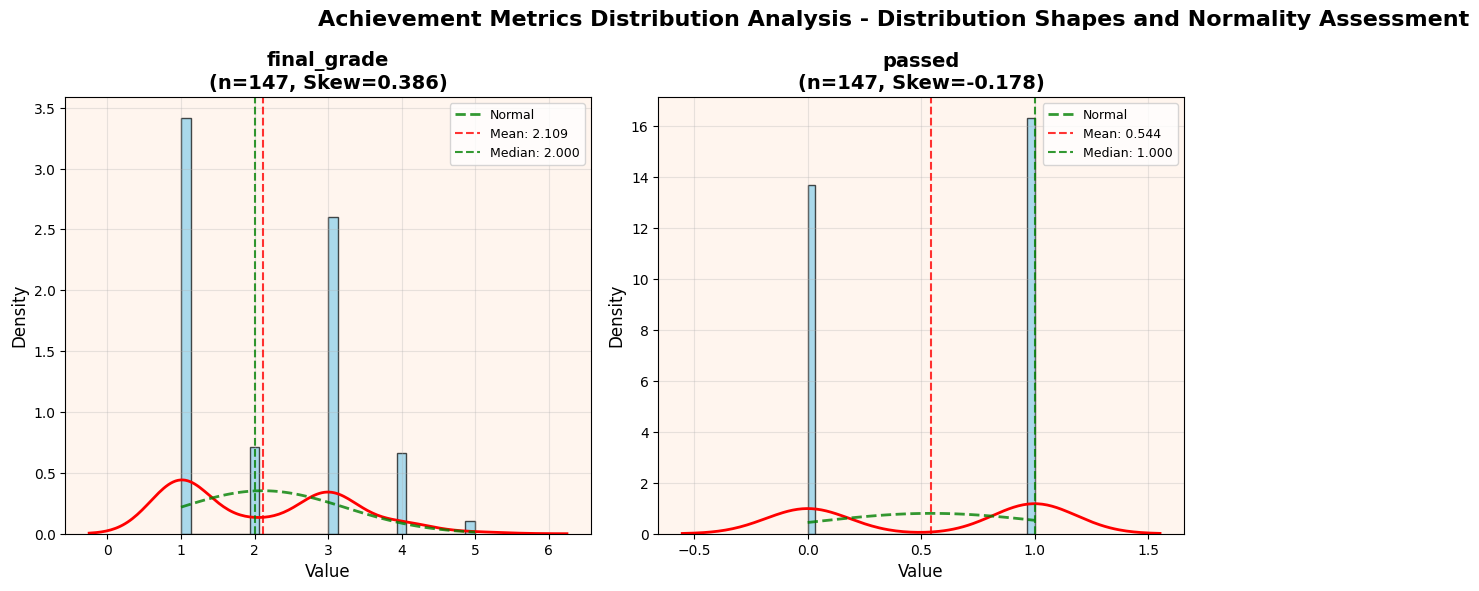


📋 SUMMARY TABLE:
   Variable   N  Mean   Std  Skewness  Is_Normal Recommended_Method
final_grade 147 2.109 1.129     0.386      False     Non-parametric
     passed 147 0.544 0.500    -0.178      False     Non-parametric

💡 STATISTICAL METHOD RECOMMENDATIONS:
Variables with normal distribution: 0/2 (0.0%)
🎯 Recommendation: Primarily use NON-PARAMETRIC methods
  • Spearman correlations
  • Mann-Whitney U tests for group comparisons
  • Kruskal-Wallis for multiple groups
  • Robust regression techniques


In [5]:
print(achievement_metrics)
# Analyze distributions of achievement metrics
if achievement_metrics:
    achievement_dist_results = comprehensive_distribution_analysis(df, achievement_metrics, "Achievement Metrics Distribution Analysis")

## 3. Correlation Analysis: How Strong is the Engagement-Achievement Connection?

['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']
['final_grade', 'passed']

🔗 COMPREHENSIVE CORRELATION ANALYSIS
📊 Base engagement metrics: ['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency', 'tests_consistency_stability', 'tests_early_late_consistency']
📊 Percentile engagement metrics: ['tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_perct', 'tests_consistency_stability_perct', 'tests_early_late_consisten

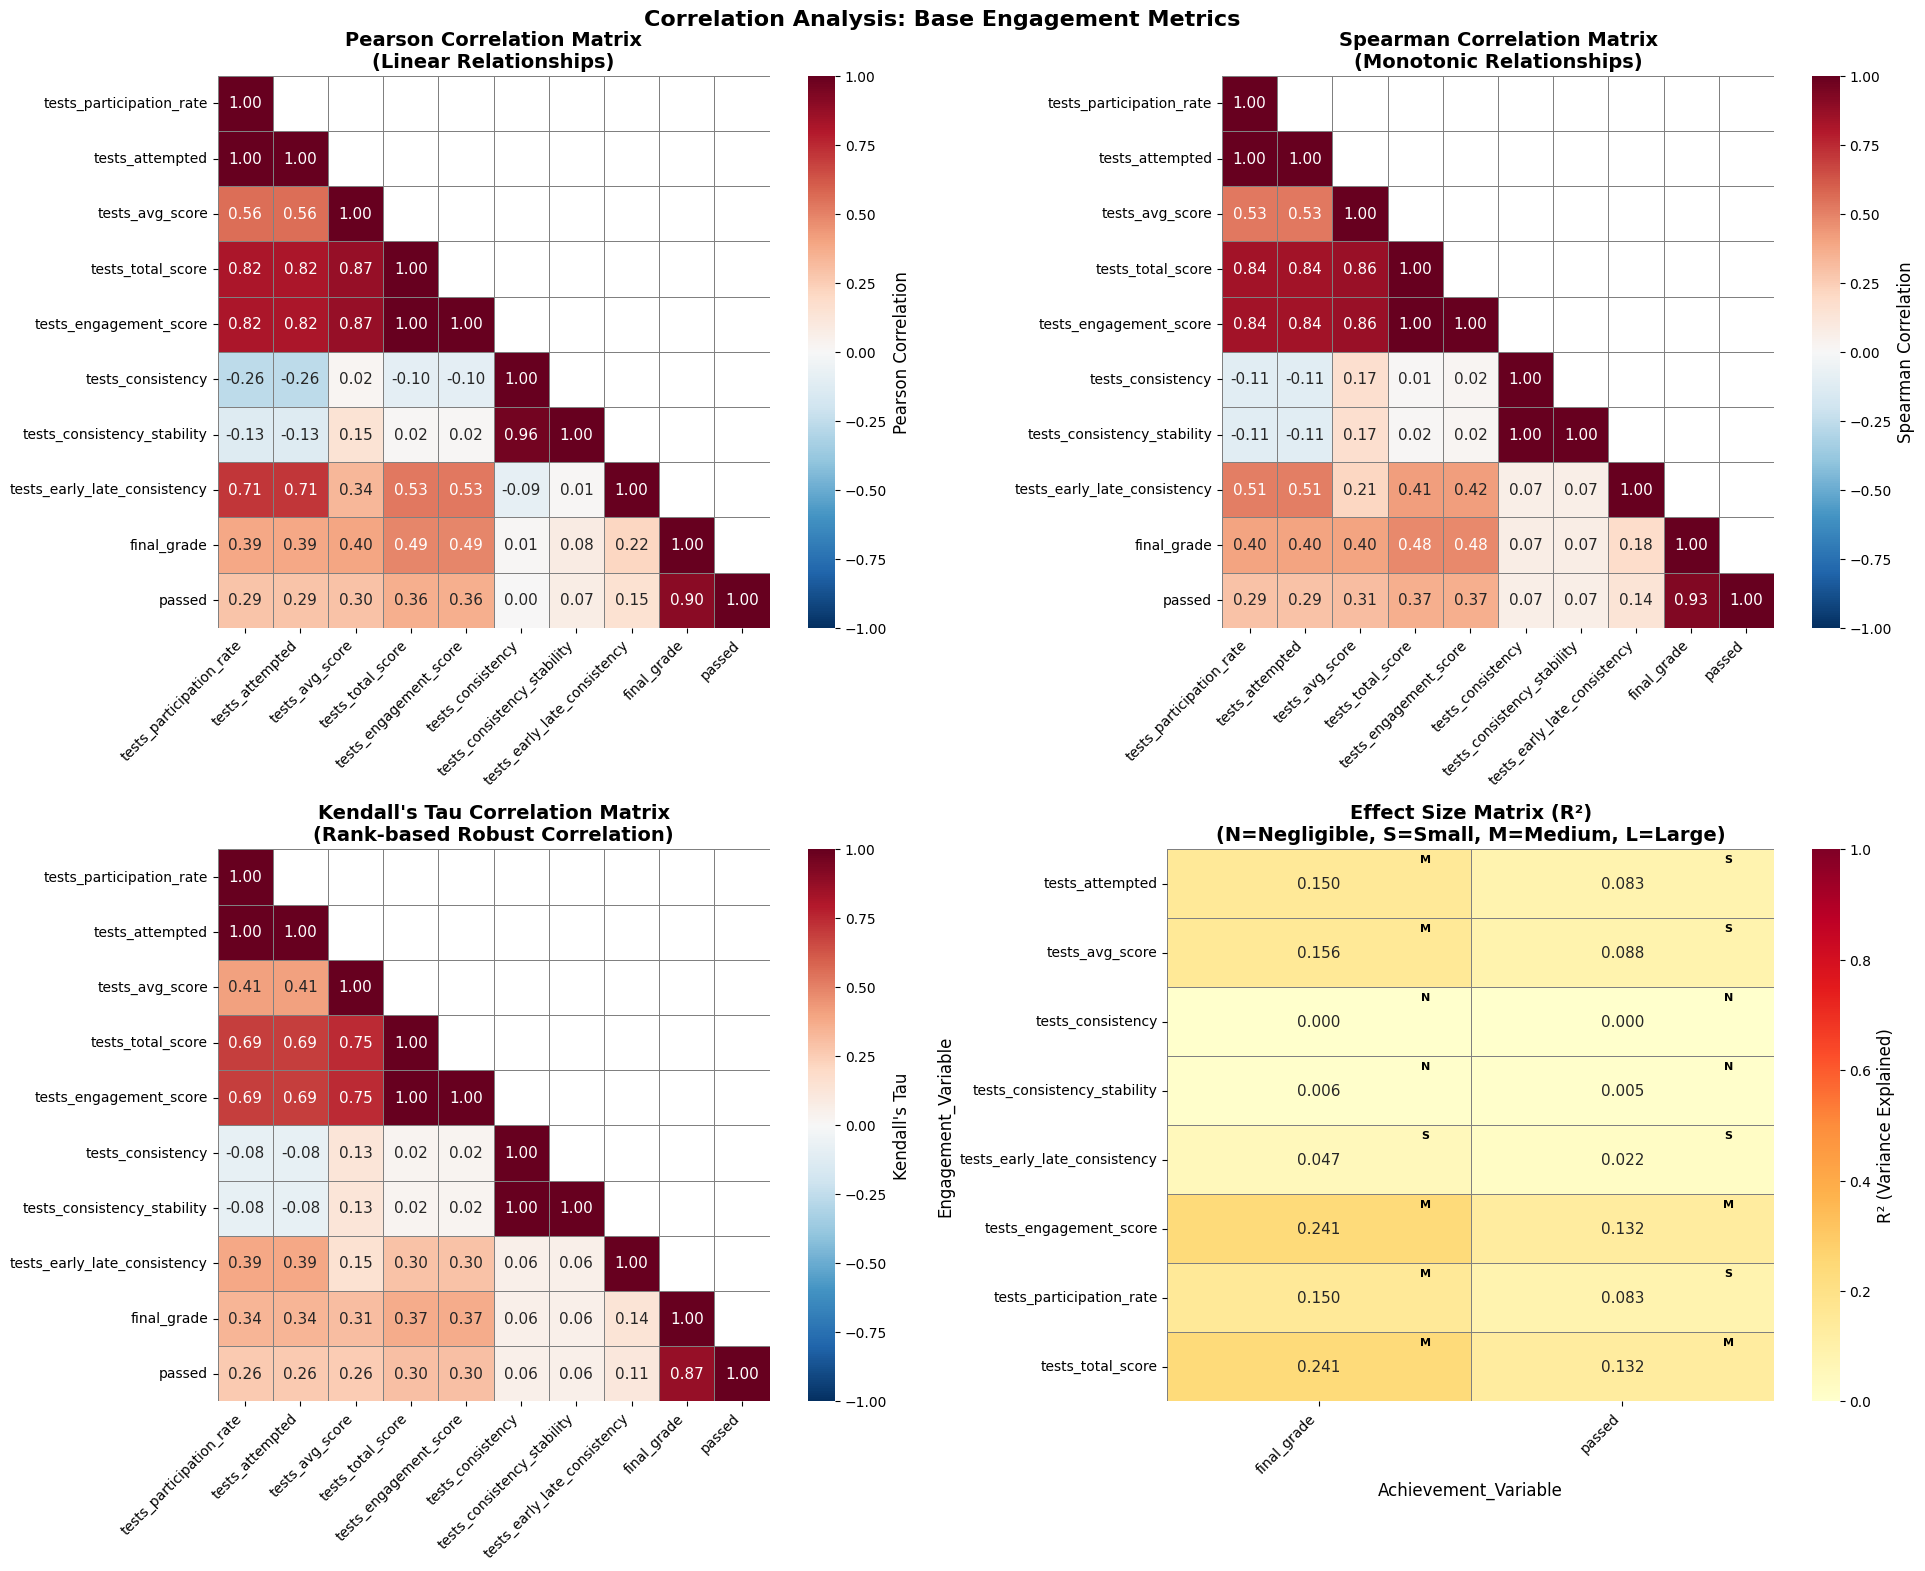


📊 ANALYZING PERCENTILE ENGAGEMENT METRICS


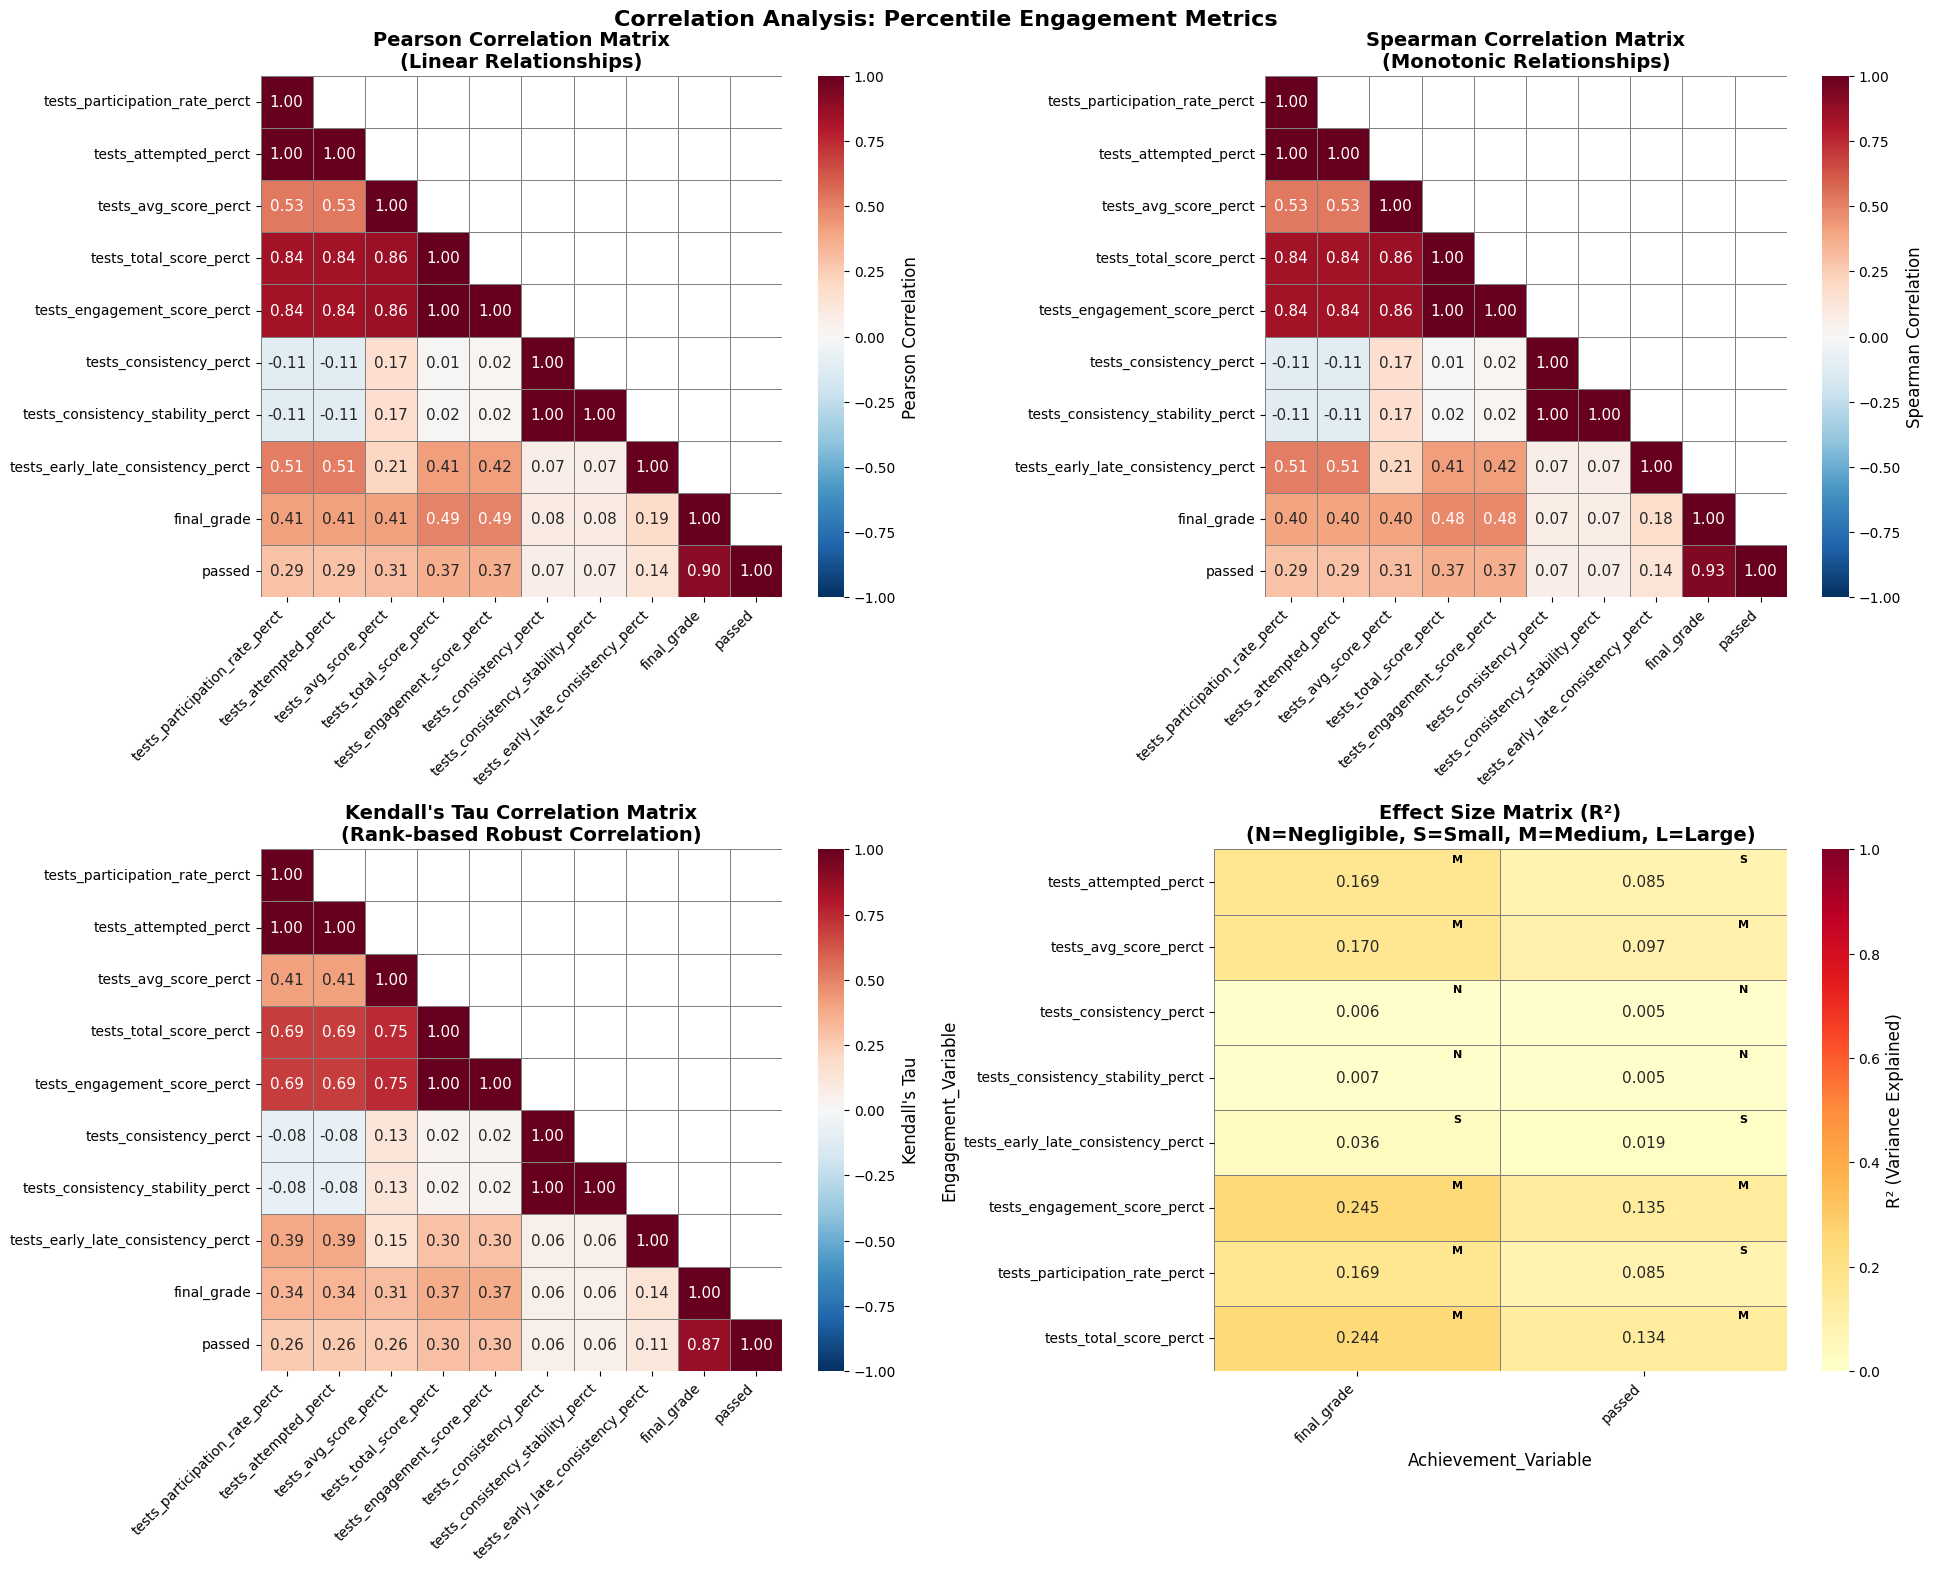


🔍 DETAILED CORRELATION ANALYSIS:

📊 BASE ENGAGEMENT METRICS:

📊 TESTS ATTEMPTED:
--------------------------------------------------
  final_grade (n=147):
    Pearson:  r =  0.388, p = 0.0000 ***
    Spearman: ρ =  0.400, p = 0.0000 ***
    Kendall:  τ =  0.337, p = 0.0000 ***
    Effect size: Medium (r² = 0.150, 15.0% variance explained)
  passed (n=147):
    Pearson:  r =  0.287, p = 0.0004 ***
    Spearman: ρ =  0.292, p = 0.0003 ***
    Kendall:  τ =  0.259, p = 0.0004 ***
    Effect size: Small (r² = 0.083, 8.3% variance explained)

📊 TESTS AVG SCORE:
--------------------------------------------------
  final_grade (n=147):
    Pearson:  r =  0.395, p = 0.0000 ***
    Spearman: ρ =  0.398, p = 0.0000 ***
    Kendall:  τ =  0.306, p = 0.0000 ***
    Effect size: Medium (r² = 0.156, 15.6% variance explained)
  passed (n=147):
    Pearson:  r =  0.296, p = 0.0003 ***
    Spearman: ρ =  0.311, p = 0.0001 ***
    Kendall:  τ =  0.256, p = 0.0002 ***
    Effect size: Small (r² = 0.088,

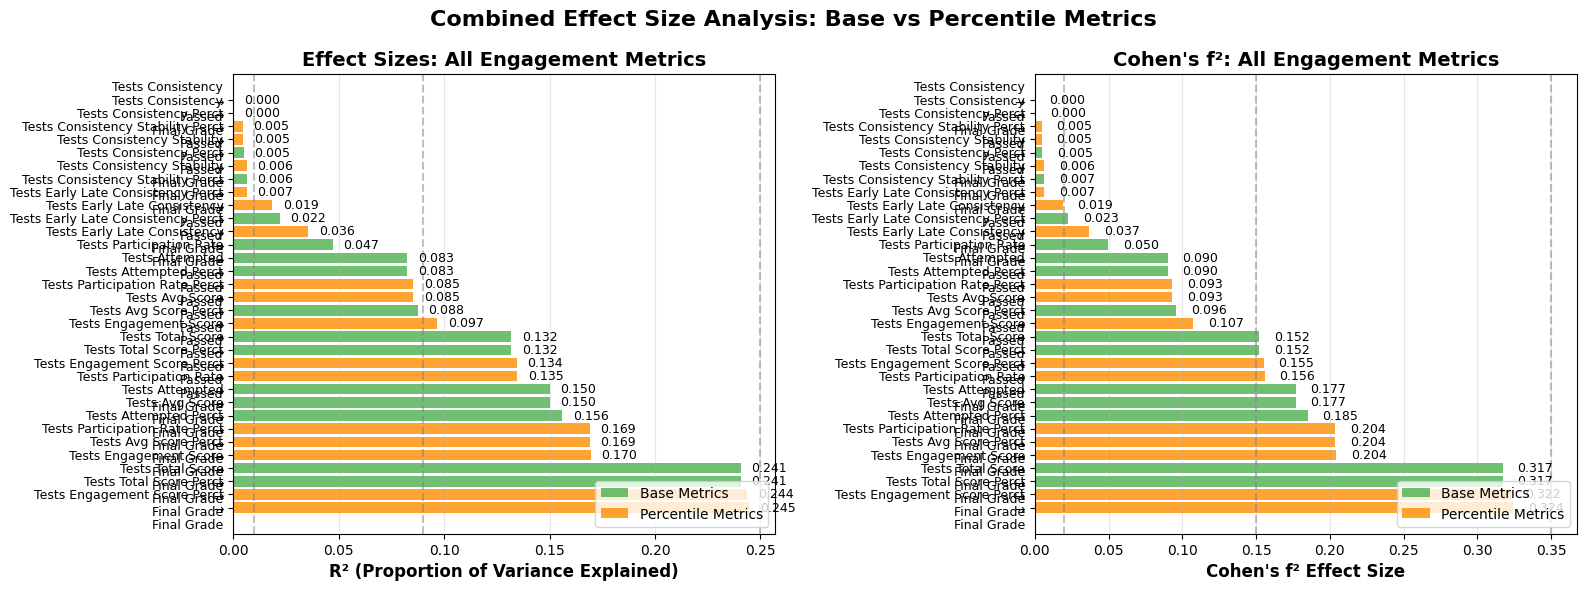


📋 CORRELATION SUMMARY TABLE:
               Engagement_Variable Achievement_Variable   N  Pearson_r  Pearson_p  Spearman_r  Spearman_p  R_squared Effect_Size
          tests_participation_rate          final_grade 147      0.388      0.000       0.400       0.000      0.150      Medium
          tests_participation_rate               passed 147      0.287      0.000       0.292       0.000      0.083       Small
                   tests_attempted          final_grade 147      0.388      0.000       0.400       0.000      0.150      Medium
                   tests_attempted               passed 147      0.287      0.000       0.292       0.000      0.083       Small
                   tests_avg_score          final_grade 147      0.395      0.000       0.398       0.000      0.156      Medium
                   tests_avg_score               passed 147      0.296      0.000       0.311       0.000      0.088       Small
                 tests_total_score          final_grade 147      0.

In [6]:
def comprehensive_correlation_analysis(data, engagement_vars, achievement_vars):
    """
    Comprehensive correlation analysis with multiple correlation types,
    significance testing, and effect size interpretation - split by percentile metrics
    """
    print(f"\n{'='*80}")
    print(f"🔗 COMPREHENSIVE CORRELATION ANALYSIS")
    print(f"{'='*80}")
    
    correlation_results = []
    
    # Split engagement metrics into base metrics and percentile metrics
    base_engagement_vars = [var for var in engagement_vars if var in data.columns and not var.endswith('_perct')]
    perct_engagement_vars = [var for var in engagement_vars if var in data.columns and var.endswith('_perct')]
    
    print(f"📊 Base engagement metrics: {base_engagement_vars}")
    print(f"📊 Percentile engagement metrics: {perct_engagement_vars}")
    
    # Function to create correlation plots for a set of variables
    def create_correlation_plots(engagement_vars_subset, title_suffix):
        # Create correlation matrix for visualization
        all_vars = engagement_vars_subset + achievement_vars
        available_vars = [var for var in all_vars if var in data.columns]
        
        if len(available_vars) < 2:
            print(f"❌ Insufficient variables for {title_suffix} correlation analysis")
            return None
        
        corr_data = data[available_vars]
        
        # Calculate different types of correlations
        pearson_corr = corr_data.corr(method='pearson')
        spearman_corr = corr_data.corr(method='spearman')
        kendall_corr = corr_data.corr(method='kendall')
        
        # Create comprehensive correlation heatmaps - all three types
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. Pearson correlation heatmap
        mask1 = np.triu(np.ones_like(pearson_corr, dtype=bool), k=1)
        sns.heatmap(pearson_corr, annot=True, cmap='RdBu_r', center=0, 
                    square=True, mask=mask1, ax=axes[0,0], fmt='.2f',
                    cbar_kws={'label': 'Pearson Correlation'},
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
        axes[0,0].set_title('Pearson Correlation Matrix\n(Linear Relationships)', 
                           fontsize=14, fontweight='bold')
        axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45, ha='right')
        axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), rotation=0)
        
        # 2. Spearman correlation heatmap
        mask2 = np.triu(np.ones_like(spearman_corr, dtype=bool), k=1)
        sns.heatmap(spearman_corr, annot=True, cmap='RdBu_r', center=0, 
                    square=True, mask=mask2, ax=axes[0,1], fmt='.2f',
                    cbar_kws={'label': 'Spearman Correlation'},
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
        axes[0,1].set_title('Spearman Correlation Matrix\n(Monotonic Relationships)', 
                           fontsize=14, fontweight='bold')
        axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45, ha='right')
        axes[0,1].set_yticklabels(axes[0,1].get_yticklabels(), rotation=0)
        
        # 3. Kendall's Tau correlation heatmap
        mask3 = np.triu(np.ones_like(kendall_corr, dtype=bool), k=1)
        sns.heatmap(kendall_corr, annot=True, cmap='RdBu_r', center=0, 
                    square=True, mask=mask3, ax=axes[1,0], fmt='.2f',
                    cbar_kws={'label': "Kendall's Tau"},
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
        axes[1,0].set_title("Kendall's Tau Correlation Matrix\n(Rank-based Robust Correlation)", 
                           fontsize=14, fontweight='bold')
        axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45, ha='right')
        axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
        
        # 4. Effect Size Visualization (R² heatmap)
        # Calculate correlations and store results for this subset
        subset_results = []
        
        for eng_var in engagement_vars_subset:
            if eng_var not in data.columns:
                continue
                
            for ach_var in achievement_vars:
                if ach_var not in data.columns:
                    continue
                
                # Get clean data
                clean_data_subset = data[[eng_var, ach_var]].dropna()
                
                if len(clean_data_subset) < 3:
                    continue
                
                # Calculate correlations with significance tests
                try:
                    # Pearson correlation
                    r_pearson, p_pearson = pearsonr(clean_data_subset[eng_var], clean_data_subset[ach_var])
                    
                    # Spearman correlation
                    r_spearman, p_spearman = spearmanr(clean_data_subset[eng_var], clean_data_subset[ach_var])
                    
                    # Kendall tau (robust rank correlation)
                    r_kendall, p_kendall = kendalltau(clean_data_subset[eng_var], clean_data_subset[ach_var])
                    
                    # Effect size interpretation
                    def interpret_correlation(r):
                        abs_r = abs(r)
                        if abs_r < 0.1:
                            return "Negligible"
                        elif abs_r < 0.3:
                            return "Small"
                        elif abs_r < 0.5:
                            return "Medium"
                        elif abs_r < 0.7:
                            return "Large"
                        else:
                            return "Very Large"
                    
                    # Variance explained (R²)
                    r_squared = r_pearson ** 2
                    
                    # Store results for summary
                    subset_results.append({
                        'Engagement_Variable': eng_var,
                        'Achievement_Variable': ach_var,
                        'N': len(clean_data_subset),
                        'Pearson_r': r_pearson,
                        'Pearson_p': p_pearson,
                        'Spearman_r': r_spearman,
                        'Spearman_p': p_spearman,
                        'Kendall_r': r_kendall,
                        'Kendall_p': p_kendall,
                        'R_squared': r_squared,
                        'Effect_Size': interpret_correlation(r_pearson)
                    })
                    
                except Exception as e:
                    continue
        
        if subset_results:
            # Create R² matrix for effect size visualization
            corr_df = pd.DataFrame(subset_results)
            
            # Create pivot table for R² values
            r_squared_matrix = pd.pivot_table(
                corr_df, 
                values='R_squared', 
                index='Engagement_Variable',
                columns='Achievement_Variable',
                aggfunc='mean'
            )
            
            # Plot R² heatmap (effect size visualization)
            ax = axes[1,1]
            
            # Create custom colormap for effect sizes
            sns.heatmap(r_squared_matrix, annot=True, cmap='YlOrRd', 
                        square=False, ax=ax, fmt='.3f',
                        cbar_kws={'label': 'R² (Variance Explained)'},
                        vmin=0, vmax=1, linewidths=0.5, linecolor='gray')
            
            # Add effect size interpretation as text
            for i, eng_var in enumerate(r_squared_matrix.index):
                for j, ach_var in enumerate(r_squared_matrix.columns):
                    r_sq = r_squared_matrix.iloc[i, j]
                    if pd.notna(r_sq):
                        # Determine effect size category
                        if r_sq < 0.01:
                            effect_text = 'N'  # Negligible
                        elif r_sq < 0.09:
                            effect_text = 'S'  # Small
                        elif r_sq < 0.25:
                            effect_text = 'M'  # Medium
                        else:
                            effect_text = 'L'  # Large
                        
                        # Add small text indicator in corner
                        ax.text(j + 0.85, i + 0.15, effect_text, 
                               fontsize=8, fontweight='bold', 
                               color='white' if r_sq > 0.5 else 'black',
                               ha='center', va='center')
            
            ax.set_title('Effect Size Matrix (R²)\n(N=Negligible, S=Small, M=Medium, L=Large)', 
                        fontsize=14, fontweight='bold')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
        plt.suptitle(f'Correlation Analysis: {title_suffix}', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return subset_results
    
    # Create plots for base engagement metrics
    if base_engagement_vars:
        print(f"\n{'='*60}")
        print(f"📊 ANALYZING BASE ENGAGEMENT METRICS")
        print(f"{'='*60}")
        
        base_results = create_correlation_plots(base_engagement_vars, "Base Engagement Metrics")
        if base_results:
            correlation_results.extend(base_results)
    
    # Create plots for percentile engagement metrics
    if perct_engagement_vars:
        print(f"\n{'='*60}")
        print(f"📊 ANALYZING PERCENTILE ENGAGEMENT METRICS")
        print(f"{'='*60}")
        
        perct_results = create_correlation_plots(perct_engagement_vars, "Percentile Engagement Metrics")
        if perct_results:
            correlation_results.extend(perct_results)
    
    # Detailed correlation analysis (text output)
    print(f"\n🔍 DETAILED CORRELATION ANALYSIS:")
    print("="*60)
    
    # Analyze base metrics first
    if base_engagement_vars:
        print(f"\n📊 BASE ENGAGEMENT METRICS:")
        print("="*50)
        
        for eng_var in sorted(base_engagement_vars):  # Sort consistently
            if eng_var not in data.columns:
                continue
                
            print(f"\n📊 {eng_var.upper().replace('_', ' ')}:")
            print("-" * 50)
            
            for ach_var in achievement_vars:
                if ach_var not in data.columns:
                    continue
                
                # Get clean data
                clean_data = data[[eng_var, ach_var]].dropna()
                
                if len(clean_data) < 3:
                    print(f"  {ach_var}: Insufficient data (n={len(clean_data)})")
                    continue
                
                # Calculate correlations with significance tests
                try:
                    # Pearson correlation
                    r_pearson, p_pearson = pearsonr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Spearman correlation
                    r_spearman, p_spearman = spearmanr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Kendall tau (robust rank correlation)
                    r_kendall, p_kendall = kendalltau(clean_data[eng_var], clean_data[ach_var])
                    
                    # Variance explained (R²)
                    r_squared = r_pearson ** 2
                    
                    print(f"  {ach_var} (n={len(clean_data)}):")
                    print(f"    Pearson:  r = {r_pearson:6.3f}, p = {p_pearson:.4f} {'***' if p_pearson < 0.001 else '**' if p_pearson < 0.01 else '*' if p_pearson < 0.05 else 'ns'}")
                    print(f"    Spearman: ρ = {r_spearman:6.3f}, p = {p_spearman:.4f} {'***' if p_spearman < 0.001 else '**' if p_spearman < 0.01 else '*' if p_spearman < 0.05 else 'ns'}")
                    print(f"    Kendall:  τ = {r_kendall:6.3f}, p = {p_kendall:.4f} {'***' if p_kendall < 0.001 else '**' if p_kendall < 0.01 else '*' if p_kendall < 0.05 else 'ns'}")
                    
                    # Effect size interpretation
                    def interpret_correlation(r):
                        abs_r = abs(r)
                        if abs_r < 0.1:
                            return "Negligible"
                        elif abs_r < 0.3:
                            return "Small"
                        elif abs_r < 0.5:
                            return "Medium"
                        elif abs_r < 0.7:
                            return "Large"
                        else:
                            return "Very Large"
                    
                    print(f"    Effect size: {interpret_correlation(r_pearson)} (r² = {r_squared:.3f}, {r_squared*100:.1f}% variance explained)")
                    
                except Exception as e:
                    print(f"  {ach_var}: Error calculating correlations - {str(e)}")
    
    # Analyze percentile metrics
    if perct_engagement_vars:
        print(f"\n📊 PERCENTILE ENGAGEMENT METRICS:")
        print("="*50)
        
        for eng_var in sorted(perct_engagement_vars):  # Sort consistently
            if eng_var not in data.columns:
                continue
                
            print(f"\n📊 {eng_var.upper().replace('_', ' ')}:")
            print("-" * 50)
            
            for ach_var in achievement_vars:
                if ach_var not in data.columns:
                    continue
                
                # Get clean data
                clean_data = data[[eng_var, ach_var]].dropna()
                
                if len(clean_data) < 3:
                    print(f"  {ach_var}: Insufficient data (n={len(clean_data)})")
                    continue
                
                # Calculate correlations with significance tests
                try:
                    # Pearson correlation
                    r_pearson, p_pearson = pearsonr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Spearman correlation
                    r_spearman, p_spearman = spearmanr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Kendall tau (robust rank correlation)
                    r_kendall, p_kendall = kendalltau(clean_data[eng_var], clean_data[ach_var])
                    
                    # Variance explained (R²)
                    r_squared = r_pearson ** 2
                    
                    print(f"  {ach_var} (n={len(clean_data)}):")
                    print(f"    Pearson:  r = {r_pearson:6.3f}, p = {p_pearson:.4f} {'***' if p_pearson < 0.001 else '**' if p_pearson < 0.01 else '*' if p_pearson < 0.05 else 'ns'}")
                    print(f"    Spearman: ρ = {r_spearman:6.3f}, p = {p_spearman:.4f} {'***' if p_spearman < 0.001 else '**' if p_spearman < 0.01 else '*' if p_spearman < 0.05 else 'ns'}")
                    print(f"    Kendall:  τ = {r_kendall:6.3f}, p = {p_kendall:.4f} {'***' if p_kendall < 0.001 else '**' if p_kendall < 0.01 else '*' if p_kendall < 0.05 else 'ns'}")
                    print(f"    Effect size: {interpret_correlation(r_pearson)} (r² = {r_squared:.3f}, {r_squared*100:.1f}% variance explained)")
                    
                except Exception as e:
                    print(f"  {ach_var}: Error calculating correlations - {str(e)}")
    
    # Additional Effect Size Visualization - Bar chart (combined)
    if correlation_results:
        # Create a separate figure for effect size comparison
        fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
        
        # Sort by R² for better visualization
        corr_df = pd.DataFrame(correlation_results)
        corr_df_sorted = corr_df.sort_values('R_squared', ascending=False)
        
        # Create labels for each correlation
        corr_df_sorted['Pair'] = corr_df_sorted['Engagement_Variable'].str.replace('_', ' ').str.title() + '\n→\n' + \
                                 corr_df_sorted['Achievement_Variable'].str.replace('_', ' ').str.title()
        
        # Color by metric type
        colors = []
        for var in corr_df_sorted['Engagement_Variable']:
            if var.endswith('_perct'):
                colors.append('#ff8c00')  # Orange for percentile metrics
            else:
                colors.append('#4CAF50')  # Green for base metrics
        
        # 1. R² Bar Chart
        ax1 = axes2[0]
        bars = ax1.barh(range(len(corr_df_sorted)), corr_df_sorted['R_squared'], color=colors, alpha=0.8)
        
        ax1.set_yticks(range(len(corr_df_sorted)))
        ax1.set_yticklabels(corr_df_sorted['Pair'], fontsize=9)
        ax1.set_xlabel('R² (Proportion of Variance Explained)', fontweight='bold')
        ax1.set_title('Effect Sizes: All Engagement Metrics', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Add legend for colors
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#4CAF50', alpha=0.8, label='Base Metrics'),
                          Patch(facecolor='#ff8c00', alpha=0.8, label='Percentile Metrics')]
        ax1.legend(handles=legend_elements, loc='lower right')
        
        # Add reference lines for effect size categories
        ax1.axvline(x=0.01, color='gray', linestyle='--', alpha=0.5)
        ax1.axvline(x=0.09, color='gray', linestyle='--', alpha=0.5)
        ax1.axvline(x=0.25, color='gray', linestyle='--', alpha=0.5)
        
        # Add value labels
        for i, (idx, row) in enumerate(corr_df_sorted.iterrows()):
            ax1.text(row['R_squared'] + 0.005, i, f"{row['R_squared']:.3f}", 
                    va='center', fontsize=9)
        
        # 2. Cohen's f² Effect Size
        ax2 = axes2[1]
        
        # Calculate Cohen's f² from R²
        corr_df_sorted['Cohens_f2'] = corr_df_sorted['R_squared'] / (1 - corr_df_sorted['R_squared'])
        
        bars2 = ax2.barh(range(len(corr_df_sorted)), corr_df_sorted['Cohens_f2'], color=colors, alpha=0.8)
        
        ax2.set_yticks(range(len(corr_df_sorted)))
        ax2.set_yticklabels(corr_df_sorted['Pair'], fontsize=9)
        ax2.set_xlabel("Cohen's f² Effect Size", fontweight='bold')
        ax2.set_title("Cohen's f²: All Engagement Metrics", fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Add legend
        ax2.legend(handles=legend_elements, loc='lower right')
        
        # Add reference lines for Cohen's f² thresholds
        ax2.axvline(x=0.02, color='gray', linestyle='--', alpha=0.5)
        ax2.axvline(x=0.15, color='gray', linestyle='--', alpha=0.5)
        ax2.axvline(x=0.35, color='gray', linestyle='--', alpha=0.5)
        
        # Add value labels
        for i, (idx, row) in enumerate(corr_df_sorted.iterrows()):
            ax2.text(row['Cohens_f2'] + 0.01, i, f"{row['Cohens_f2']:.3f}", 
                    va='center', fontsize=9)
        
        plt.suptitle('Combined Effect Size Analysis: Base vs Percentile Metrics', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Summary statistics
    if correlation_results:
        corr_summary_df = pd.DataFrame(correlation_results)
        
        print(f"\n📋 CORRELATION SUMMARY TABLE:")
        print(f"{'='*80}")
        
        summary_display = corr_summary_df[['Engagement_Variable', 'Achievement_Variable', 'N', 
                                          'Pearson_r', 'Pearson_p', 'Spearman_r', 'Spearman_p', 
                                          'R_squared', 'Effect_Size']].round(3)
        print(summary_display.to_string(index=False))
        
        # Key findings
        significant_correlations = corr_summary_df[corr_summary_df['Pearson_p'] < 0.05]
        strong_correlations = significant_correlations[abs(significant_correlations['Pearson_r']) >= 0.5]
        
        print(f"\n🎯 KEY FINDINGS:")
        print(f"{'='*50}")
        print(f"Total correlations analyzed: {len(corr_summary_df)}")
        print(f"Significant correlations (p < 0.05): {len(significant_correlations)} ({len(significant_correlations)/len(corr_summary_df)*100:.1f}%)")
        print(f"Strong correlations (|r| ≥ 0.5): {len(strong_correlations)} ({len(strong_correlations)/len(corr_summary_df)*100:.1f}%)")
        
        # Compare base vs percentile metrics
        base_corrs = corr_summary_df[~corr_summary_df['Engagement_Variable'].str.endswith('_perct')]
        perct_corrs = corr_summary_df[corr_summary_df['Engagement_Variable'].str.endswith('_perct')]
        
        if len(base_corrs) > 0 and len(perct_corrs) > 0:
            print(f"\n📊 BASE vs PERCENTILE METRICS COMPARISON:")
            print(f"{'='*50}")
            print(f"Base metrics - Mean R²: {base_corrs['R_squared'].mean():.3f}")
            print(f"Percentile metrics - Mean R²: {perct_corrs['R_squared'].mean():.3f}")
            
            if perct_corrs['R_squared'].mean() > base_corrs['R_squared'].mean():
                print("✅ Percentile metrics show stronger correlations on average")
            else:
                print("✅ Base metrics show stronger correlations on average")
        
        return corr_summary_df
    
    return None


print(engagement_metrics)
print(achievement_metrics)

# Perform comprehensive correlation analysis with split metrics
if 'engagement_metrics' in locals() and achievement_metrics:
    correlation_results_df = comprehensive_correlation_analysis(df, engagement_metrics, achievement_metrics)

🎯 COMPREHENSIVE ENGAGEMENT LEVEL ANALYSIS
Starting comprehensive engagement group analysis...

📊 STEP 1: Using Existing Engagement Score
Using existing engagement metric: tests_engagement_score
  Mean: 0.480
  Std:  0.258
  Min:  0.000
  Max:  0.933

📊 STEP 2: Creating Engagement Level Groups (Quantile Split)
Quantile thresholds for tests_engagement_score:
  33rd percentile (Low/Mid boundary): 0.333
  67th percentile (Mid/High boundary): 0.634

Engagement group distribution:
  Low :  51 students ( 34.7%) - Mean engagement: 0.190
  Mid :  49 students ( 33.3%) - Mean engagement: 0.502
  High:  47 students ( 32.0%) - Mean engagement: 0.772

📊 STEP 3: Statistical Analysis by Engagement Groups
Analyzing 5 key metrics across engagement groups

🔬 NORMALITY TESTING FOR TEST SELECTION:
--------------------------------------------------
  tests_participation_rate: Non-normal (p=0.0000)
  tests_avg_score: Non-normal (p=0.0002)
  tests_engagement_score: Non-normal (p=0.0004)
  final_grade: Non-nor

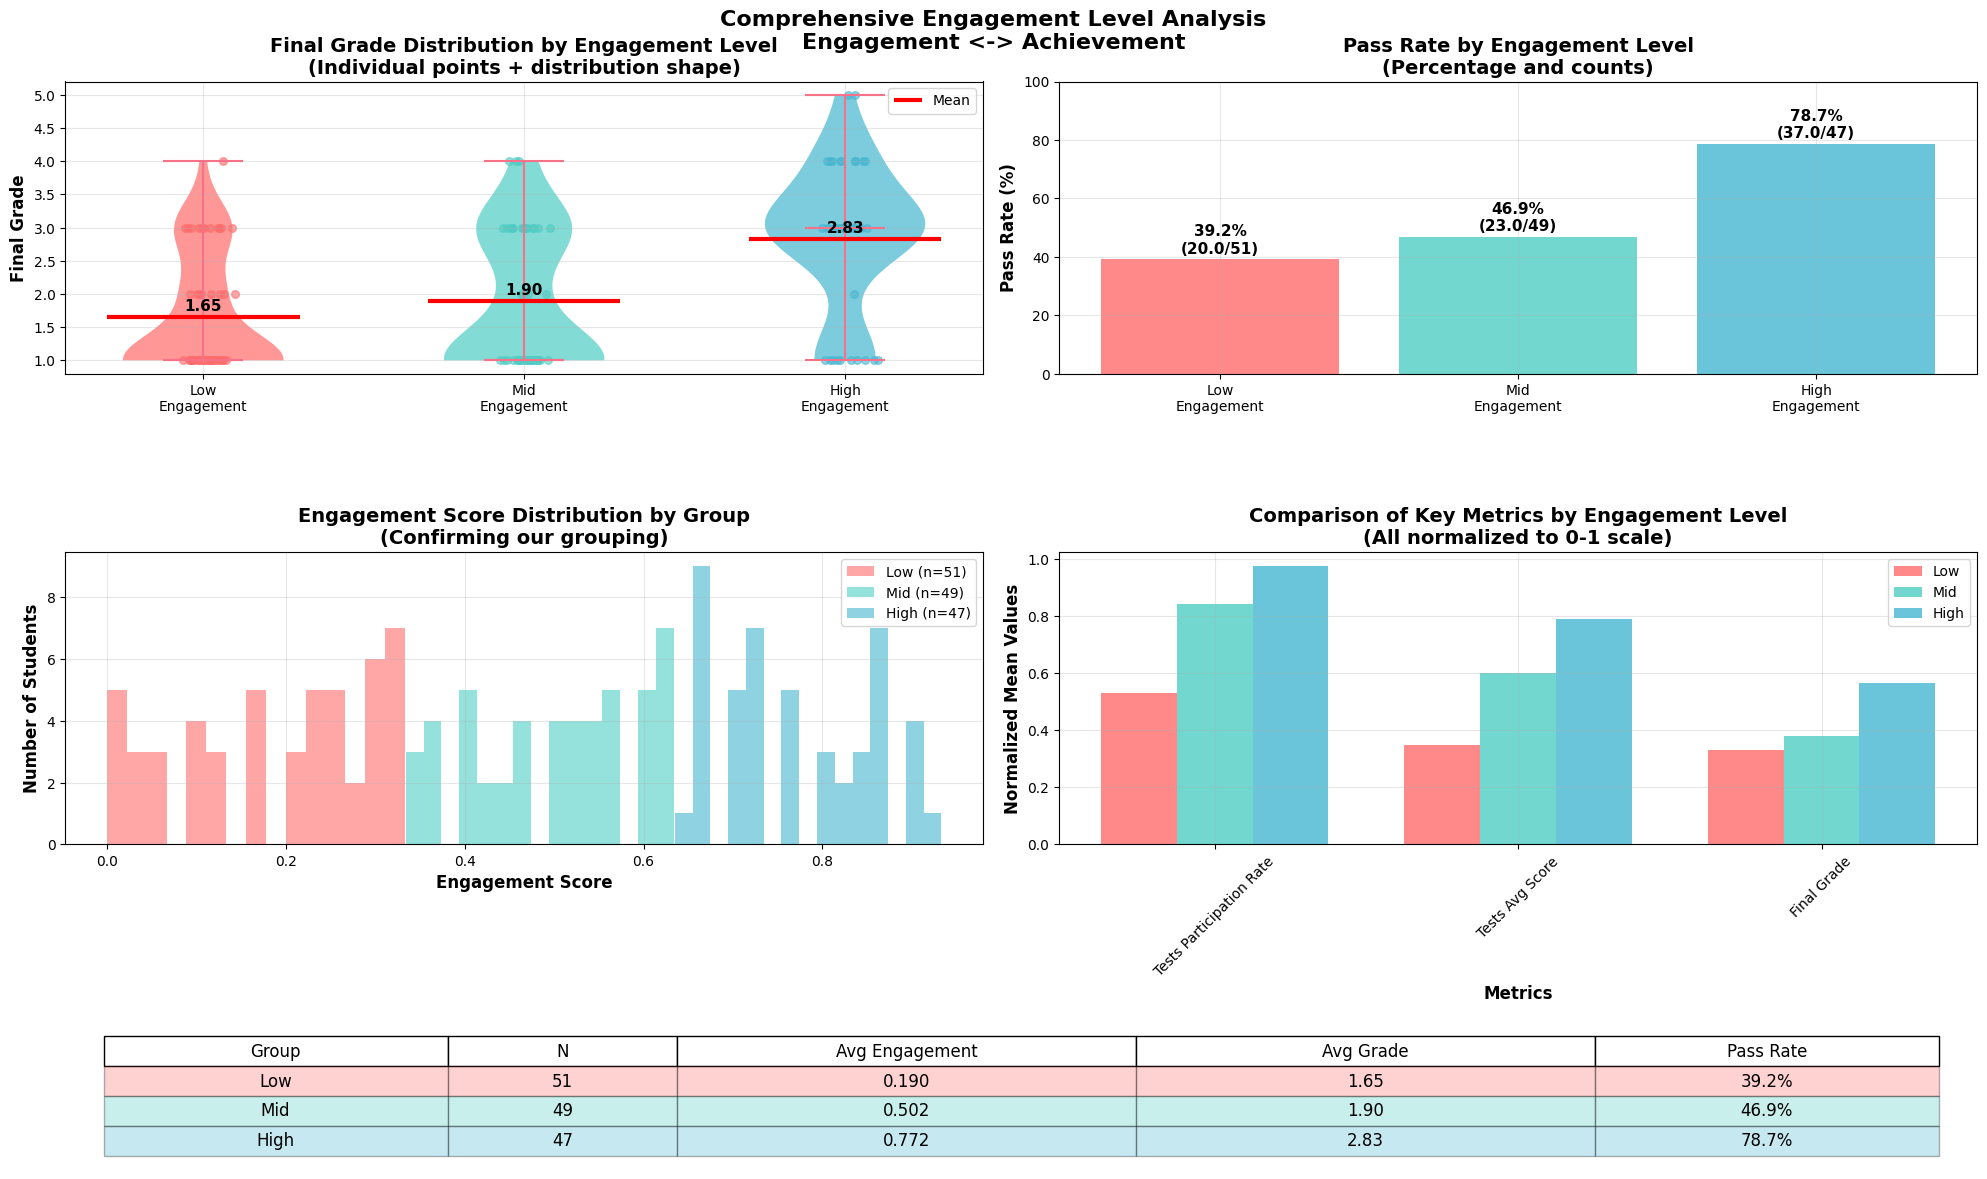


📖 EXECUTIVE SUMMARY

🎯 MAIN FINDINGS:

📊 GROUP SIZES:
• Low Engagement: 51 students (bottom 1/3)
• Mid Engagement: 49 students (middle 1/3)  
• High Engagement: 47 students (top 1/3)

🏆 ACHIEVEMENT OUTCOMES:

• Final Grades: ✅ SIGNIFICANT
  Low: 1.65 → High: 2.83 (difference: 1.18 points)
  Practical Impact: HIGH - Meaningful differences that matter for student success
• Pass Rates: ✅ SIGNIFICANT
  Low: 39.2% → High: 78.7% (difference: 39.5 points)
  Practical Impact: HIGH - Meaningful differences that matter for student success

💡 KEY TAKEAWAYS:
• Students are successfully divided into distinct engagement levels
• Higher engagement is associated with better academic outcomes
• The visualizations clearly show the relationship between engagement and performance
• Effect sizes indicate meaningful practical differences

⚠️  IMPORTANT NOTES:
• This shows association, not causation
• High achievers might naturally be more engaged
• Multiple factors influence both engagement and grades
• Re

In [7]:
# Comprehensive Analysis: Engagement Level Groups (Low, Mid, High)
# Split students by engagement level using quantile approach and analyze differences across all metrics

print("="*80)
print("🎯 COMPREHENSIVE ENGAGEMENT LEVEL ANALYSIS")
print("="*80)

def create_engagement_groups_and_analyze(data, engagement_metrics_list, achievement_metrics_list):
    """
    Create engagement level groups using existing engagement score and perform comprehensive statistical analysis
    """
    
    # Step 1: Use Existing Engagement Score
    print("\n📊 STEP 1: Using Existing Engagement Score")
    print("="*50)
    
    # Use the existing tests_engagement_score
    if 'tests_engagement_score' not in data.columns:
        print("❌ tests_engagement_score not found in dataset")
        return None
    
    engagement_score_col = 'tests_engagement_score'
    print(f"Using existing engagement metric: {engagement_score_col}")
    print(f"  Mean: {data[engagement_score_col].mean():.3f}")
    print(f"  Std:  {data[engagement_score_col].std():.3f}")
    print(f"  Min:  {data[engagement_score_col].min():.3f}")
    print(f"  Max:  {data[engagement_score_col].max():.3f}")
    
    # Step 2: Create Engagement Level Groups using Quantiles
    print("\n📊 STEP 2: Creating Engagement Level Groups (Quantile Split)")
    print("="*65)
    
    # Calculate quantiles
    q33 = data[engagement_score_col].quantile(0.32)
    q67 = data[engagement_score_col].quantile(0.68)
    
    print(f"Quantile thresholds for {engagement_score_col}:")
    print(f"  33rd percentile (Low/Mid boundary): {q33:.3f}")
    print(f"  67th percentile (Mid/High boundary): {q67:.3f}")
    
    # Create engagement groups
    def assign_engagement_group(score):
        if pd.isna(score):
            return np.nan
        elif score <= q33:
            return 'Low'
        elif score <= q67:
            return 'Mid'
        else:
            return 'High'
    
    data['engagement_group'] = data[engagement_score_col].apply(assign_engagement_group)
    
    # Display group statistics
    group_counts = data['engagement_group'].value_counts().sort_index()
    group_percentages = data['engagement_group'].value_counts(normalize=True).sort_index() * 100
    
    print(f"\nEngagement group distribution:")
    for group in ['Low', 'Mid', 'High']:
        count = group_counts.get(group, 0)
        pct = group_percentages.get(group, 0)
        group_data = data[data['engagement_group'] == group][engagement_score_col].dropna()
        mean_score = group_data.mean() if len(group_data) > 0 else np.nan
        print(f"  {group:4s}: {count:3d} students ({pct:5.1f}%) - Mean engagement: {mean_score:.3f}")
    
    # Step 3: Enhanced Statistical Analysis with Individual Metric Interpretations
    print("\n📊 STEP 3: Statistical Analysis by Engagement Groups")
    print("="*55)
    
    # Focus on key metrics for analysis
    key_metrics = ['tests_participation_rate', 'tests_avg_score', 'tests_engagement_score', 
                   'final_grade', 'passed']
    available_metrics = [metric for metric in key_metrics if metric in data.columns]
    
    print(f"Analyzing {len(available_metrics)} key metrics across engagement groups")
    
    # Perform normality tests first
    print(f"\n🔬 NORMALITY TESTING FOR TEST SELECTION:")
    print("-" * 50)
    
    normality_results = {}
    for metric in available_metrics:
        metric_data = data[metric].dropna()
        if len(metric_data) < 8:
            normality_results[metric] = False
            continue
            
        try:
            _, p_value = shapiro(metric_data)
            is_normal = p_value > 0.05
            normality_results[metric] = is_normal
            print(f"  {metric}: {'Normal' if is_normal else 'Non-normal'} (p={p_value:.4f})")
        except:
            normality_results[metric] = False
            print(f"  {metric}: Non-normal (test failed)")
    
    # Enhanced statistical testing with detailed interpretations
    def perform_enhanced_group_comparison(data, metric):
        """
        Perform statistical test with enhanced interpretations
        """
        results = {
            'metric': metric,
            'test_used': None,
            'statistic': None,
            'p_value': None,
            'effect_size': None,
            'interpretation': None,
            'layman_explanation': None,
            'group_stats': {},
            'practical_significance': None
        }
        
        # Get data for each group
        group_data = {}
        for group in ['Low', 'Mid', 'High']:
            group_subset = data[data['engagement_group'] == group][metric].dropna()
            group_data[group] = group_subset
            results['group_stats'][group] = {
                'n': len(group_subset),
                'mean': group_subset.mean() if len(group_subset) > 0 else np.nan,
                'median': group_subset.median() if len(group_subset) > 0 else np.nan,
                'std': group_subset.std() if len(group_subset) > 0 else np.nan
            }
        
        # Filter out empty groups
        valid_groups = {k: v for k, v in group_data.items() if len(v) > 0}
        
        if len(valid_groups) < 3:
            results['interpretation'] = 'Insufficient groups for comparison'
            return results
        
        # Check sample size
        total_n = sum(len(v) for v in valid_groups.values())
        if total_n < 15:
            results['interpretation'] = 'Insufficient sample size for reliable testing'
            return results
        
        # Determine test based on normality
        is_metric_normal = normality_results.get(metric, False)
        
        try:
            # Three-group comparison
            group_values = [valid_groups['Low'], valid_groups['Mid'], valid_groups['High']]
            
            if is_metric_normal:
                # One-way ANOVA
                statistic, p_value = f_oneway(*group_values)
                results['test_used'] = 'One-way ANOVA'
                
                # Eta-squared effect size
                grand_mean = np.concatenate(group_values).mean()
                ss_between = sum(len(group) * (group.mean() - grand_mean)**2 for group in group_values)
                ss_total = sum((np.concatenate(group_values) - grand_mean)**2)
                eta_squared = ss_between / ss_total if ss_total > 0 else 0
                results['effect_size'] = eta_squared
            else:
                # Kruskal-Wallis test
                statistic, p_value = kruskal(*group_values)
                results['test_used'] = 'Kruskal-Wallis test'
                
                # Effect size for Kruskal-Wallis
                n = total_n
                k = len(valid_groups)
                epsilon_squared = (statistic - k + 1) / (n - k) if (n - k) > 0 else 0
                results['effect_size'] = max(0, epsilon_squared)
            
            results['statistic'] = statistic
            results['p_value'] = p_value
            
            # Enhanced interpretations
            if p_value < 0.001:
                significance = "Highly significant (p < 0.001)"
            elif p_value < 0.01:
                significance = "Very significant (p < 0.01)"
            elif p_value < 0.05:
                significance = "Significant (p < 0.05)"
            else:
                significance = "Not significant (p ≥ 0.05)"
            
            # Effect size interpretation
            es = results['effect_size']
            if es < 0.01:
                effect_interp = "Negligible"
            elif es < 0.06:
                effect_interp = "Small" 
            elif es < 0.14:
                effect_interp = "Medium"
            else:
                effect_interp = "Large"
            
            results['interpretation'] = f"{significance}. Effect size: {effect_interp} ({es:.3f})"
            
            # Create detailed layman explanations
            low_mean = results['group_stats']['Low']['mean']
            mid_mean = results['group_stats']['Mid']['mean'] 
            high_mean = results['group_stats']['High']['mean']
            
            # Metric-specific explanations
            if metric == 'final_grade':
                diff_low_high = high_mean - low_mean
                results['layman_explanation'] = f"""
📊 FINAL GRADE DIFFERENCES:
• Low engagement students average: {low_mean:.2f} grade
• Mid engagement students average: {mid_mean:.2f} grade  
• High engagement students average: {high_mean:.2f} grade
• Difference (High - Low): {diff_low_high:.2f} grade points

💡 What this means: {'Students with higher engagement get significantly better grades' if p_value < 0.05 else 'No significant difference in grades between engagement groups'}. 
The effect size is {effect_interp.lower()}, meaning the practical difference is {'very meaningful' if es >= 0.14 else 'moderate' if es >= 0.06 else 'small but detectable' if es >= 0.01 else 'minimal'}.
"""
            
            elif metric == 'passed':
                low_pass_rate = low_mean * 100
                mid_pass_rate = mid_mean * 100
                high_pass_rate = high_mean * 100
                diff_pass_rate = high_pass_rate - low_pass_rate
                results['layman_explanation'] = f"""
📊 PASS RATE DIFFERENCES:
• Low engagement students: {low_pass_rate:.1f}% pass rate
• Mid engagement students: {mid_pass_rate:.1f}% pass rate
• High engagement students: {high_pass_rate:.1f}% pass rate
• Difference (High - Low): {diff_pass_rate:.1f} percentage points

💡 What this means: {'Students with higher engagement are significantly more likely to pass' if p_value < 0.05 else 'No significant difference in pass rates between engagement groups'}.
The effect size is {effect_interp.lower()}, meaning the practical difference is {'very meaningful' if es >= 0.14 else 'moderate' if es >= 0.06 else 'small but detectable' if es >= 0.01 else 'minimal'}.
"""
            
            elif 'participation' in metric:
                results['layman_explanation'] = f"""
📊 PARTICIPATION DIFFERENCES:
• Low engagement: {low_mean:.1%} participation rate
• Mid engagement: {mid_mean:.1%} participation rate  
• High engagement: {high_mean:.1%} participation rate

💡 What this means: This confirms our grouping works - {'high engagement students participate significantly more' if p_value < 0.05 else 'participation rates are similar across groups'}.
"""
            
            elif 'avg_score' in metric:
                results['layman_explanation'] = f"""
📊 TEST PERFORMANCE DIFFERENCES:
• Low engagement: {low_mean:.1%} average test score
• Mid engagement: {mid_mean:.1%} average test score
• High engagement: {high_mean:.1%} average test score

💡 What this means: {'High engagement students perform significantly better on individual tests' if p_value < 0.05 else 'Test performance is similar across engagement groups'}.
"""
            
            else:
                results['layman_explanation'] = f"""
📊 {metric.upper().replace('_', ' ')} DIFFERENCES:
• Low engagement: {low_mean:.3f}
• Mid engagement: {mid_mean:.3f}
• High engagement: {high_mean:.3f}

💡 What this means: {'There are significant differences between engagement groups for this metric' if p_value < 0.05 else 'No significant differences found between engagement groups'}.
"""
            
            # Practical significance assessment
            if metric in ['final_grade', 'passed']:
                if p_value < 0.05 and es >= 0.06:
                    results['practical_significance'] = "HIGH - Meaningful differences that matter for student success"
                elif p_value < 0.05 and es >= 0.01:
                    results['practical_significance'] = "MODERATE - Detectable differences with some practical value"
                elif p_value < 0.05:
                    results['practical_significance'] = "LOW - Statistically significant but small practical impact"
                else:
                    results['practical_significance'] = "NONE - No meaningful differences detected"
            
        except Exception as e:
            results['interpretation'] = f'Statistical test failed: {str(e)}'
            results['layman_explanation'] = "Unable to perform statistical analysis due to data issues."
        
        return results
    
    # Perform enhanced statistical tests
    print(f"\n📊 DETAILED GROUP COMPARISON RESULTS:")
    print("=" * 80)
    
    statistical_results = []
    
    for metric in available_metrics:
        print(f"\n" + "="*80)
        print(f"📈 {metric.upper().replace('_', ' ')} ANALYSIS")
        print("="*80)
        
        result = perform_enhanced_group_comparison(data, metric)
        statistical_results.append(result)
        
        # Display detailed results
        print("\n📊 GROUP STATISTICS:")
        for group in ['Low', 'Mid', 'High']:
            if group in result['group_stats']:
                stats = result['group_stats'][group]
                print(f"  {group:4s}: n={stats['n']:3d}, Mean={stats['mean']:7.3f}, Median={stats['median']:7.3f}, SD={stats['std']:6.3f}")
        
        print(f"\n🔬 STATISTICAL TEST:")
        print(f"  Test: {result['test_used']}")
        if result['statistic'] is not None:
            print(f"  Statistic: {result['statistic']:.4f}, p-value: {result['p_value']:.6f}")
        print(f"  Result: {result['interpretation']}")
        
        if result['practical_significance']:
            print(f"  Practical Significance: {result['practical_significance']}")
        
        if result['layman_explanation']:
            print(f"\n{result['layman_explanation']}")
    
    # Step 4: Enhanced Visualizations
    print(f"\n📊 STEP 4: Creating Enhanced Visualizations")
    print("=" * 50)
    
    # Focus on achievement outcomes vs engagement
    fig = plt.figure(figsize=(20, 12))
    
    # Create a comprehensive layout
    gs = fig.add_gridspec(3, 4, height_ratios=[2, 2, 1], width_ratios=[1, 1, 1, 1])
    
    colors = {'Low': '#FF6B6B', 'Mid': '#4ECDC4', 'High': '#45B7D1'}
    
    # 1. Final Grade Distribution by Engagement Group
    ax1 = fig.add_subplot(gs[0, :2])
    
    # Create violin plot for grade distribution
    grade_data = [data[data['engagement_group'] == group]['final_grade'].dropna() 
                  for group in ['Low', 'Mid', 'High']]
    
    parts = ax1.violinplot(grade_data, positions=[1, 2, 3], showmeans=True, showmedians=True)
    
    # Color the violin plots
    for i, (pc, group) in enumerate(zip(parts['bodies'], ['Low', 'Mid', 'High'])):
        pc.set_facecolor(colors[group])
        pc.set_alpha(0.7)
    
    # Add individual data points with jitter
    for i, group in enumerate(['Low', 'Mid', 'High']):
        group_grades = data[data['engagement_group'] == group]['final_grade'].dropna()
        x_vals = np.random.normal(i+1, 0.04, len(group_grades))
        ax1.scatter(x_vals, group_grades, alpha=0.6, s=30, color=colors[group])
    
    # Add mean lines
    for i, group in enumerate(['Low', 'Mid', 'High']):
        mean_grade = data[data['engagement_group'] == group]['final_grade'].mean()
        ax1.hlines(mean_grade, i+0.7, i+1.3, colors='red', linewidth=3, label='Mean' if i==0 else '')
        ax1.text(i+1, mean_grade+0.1, f'{mean_grade:.2f}', ha='center', fontweight='bold')
    
    ax1.set_xticks([1, 2, 3])
    ax1.set_xticklabels(['Low\nEngagement', 'Mid\nEngagement', 'High\nEngagement'])
    ax1.set_ylabel('Final Grade', fontweight='bold', fontsize=12)
    ax1.set_title('Final Grade Distribution by Engagement Level\n(Individual points + distribution shape)', 
                  fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Pass Rate by Engagement Group
    ax2 = fig.add_subplot(gs[0, 2:])
    
    pass_rates = []
    pass_counts = []
    total_counts = []
    
    for group in ['Low', 'Mid', 'High']:
        group_data = data[data['engagement_group'] == group]
        passed = group_data['passed'].sum()
        total = len(group_data)
        pass_rate = (passed / total * 100) if total > 0 else 0
        
        pass_rates.append(pass_rate)
        pass_counts.append(passed)
        total_counts.append(total)
    
    bars = ax2.bar(['Low\nEngagement', 'Mid\nEngagement', 'High\nEngagement'], 
                   pass_rates, color=[colors[g] for g in ['Low', 'Mid', 'High']], alpha=0.8)
    
    # Add percentage labels
    for i, (bar, rate, passed, total) in enumerate(zip(bars, pass_rates, pass_counts, total_counts)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%\n({passed}/{total})', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_ylabel('Pass Rate (%)', fontweight='bold', fontsize=12)
    ax2.set_title('Pass Rate by Engagement Level\n(Percentage and counts)', fontweight='bold', fontsize=14)
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # 3. Engagement Score Distribution (sanity check)
    ax3 = fig.add_subplot(gs[1, :2])
    
    for group in ['Low', 'Mid', 'High']:
        group_scores = data[data['engagement_group'] == group]['tests_engagement_score'].dropna()
        ax3.hist(group_scores, alpha=0.6, label=f'{group} (n={len(group_scores)})', 
                color=colors[group], bins=15)
    
    ax3.set_xlabel('Engagement Score', fontweight='bold')
    ax3.set_ylabel('Number of Students', fontweight='bold')
    ax3.set_title('Engagement Score Distribution by Group\n(Confirming our grouping)', fontweight='bold', fontsize=14)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Mean Comparison Chart
    ax4 = fig.add_subplot(gs[1, 2:])
    
    metrics_for_comparison = ['tests_participation_rate', 'tests_avg_score', 'final_grade']
    available_comparison_metrics = [m for m in metrics_for_comparison if m in data.columns]
    
    x_pos = np.arange(len(available_comparison_metrics))
    width = 0.25
    
    for i, group in enumerate(['Low', 'Mid', 'High']):
        means = []
        for metric in available_comparison_metrics:
            group_mean = data[data['engagement_group'] == group][metric].mean()
            # Normalize to 0-1 scale for comparison
            if metric == 'final_grade':
                group_mean = group_mean / 5.0  # Grades are 1-5, normalize to 0-1
            means.append(group_mean)
        
        ax4.bar(x_pos + i*width, means, width, label=group, color=colors[group], alpha=0.8)
    
    ax4.set_xlabel('Metrics', fontweight='bold')
    ax4.set_ylabel('Normalized Mean Values', fontweight='bold')
    ax4.set_title('Comparison of Key Metrics by Engagement Level\n(All normalized to 0-1 scale)', 
                  fontweight='bold', fontsize=14)
    ax4.set_xticks(x_pos + width)
    ax4.set_xticklabels([m.replace('_', ' ').title() for m in available_comparison_metrics], rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Summary Statistics Table
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    # Create summary table data
    summary_data = []
    for group in ['Low', 'Mid', 'High']:
        group_data = data[data['engagement_group'] == group]
        row = [
            group,
            len(group_data),
            f"{group_data['tests_engagement_score'].mean():.3f}",
            f"{group_data['final_grade'].mean():.2f}",
            f"{group_data['passed'].mean()*100:.1f}%"
        ]
        summary_data.append(row)
    
    table = ax5.table(cellText=summary_data,
                     colLabels=['Group', 'N', 'Avg Engagement', 'Avg Grade', 'Pass Rate'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15, 0.1, 0.2, 0.2, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2)
    
    # Color code the rows
    for i, group in enumerate(['Low', 'Mid', 'High']):
        for j in range(5):
            table[(i+1, j)].set_facecolor(colors[group])
            table[(i+1, j)].set_alpha(0.3)
    
    plt.suptitle('Comprehensive Engagement Level Analysis\n' +
                'Engagement <-> Achievement', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Step 5: Executive Summary
    print(f"\n📖 EXECUTIVE SUMMARY")
    print("=" * 50)
    
    # Count significant achievement results
    achievement_results = [r for r in statistical_results if r['metric'] in ['final_grade', 'passed']]
    significant_achievement = [r for r in achievement_results if r['p_value'] is not None and r['p_value'] < 0.05]
    
    print(f"""
🎯 MAIN FINDINGS:

📊 GROUP SIZES:
• Low Engagement: {group_counts.get('Low', 0)} students (bottom 1/3)
• Mid Engagement: {group_counts.get('Mid', 0)} students (middle 1/3)  
• High Engagement: {group_counts.get('High', 0)} students (top 1/3)

🏆 ACHIEVEMENT OUTCOMES:
""")
    
    for result in achievement_results:
        metric_name = "Final Grades" if result['metric'] == 'final_grade' else "Pass Rates"
        significance = "✅ SIGNIFICANT" if result['p_value'] < 0.05 else "❌ NOT SIGNIFICANT"
        
        low_val = result['group_stats']['Low']['mean']
        high_val = result['group_stats']['High']['mean']
        
        if result['metric'] == 'final_grade':
            print(f"• {metric_name}: {significance}")
            print(f"  Low: {low_val:.2f} → High: {high_val:.2f} (difference: {high_val-low_val:.2f} points)")
        else:
            print(f"• {metric_name}: {significance}")
            print(f"  Low: {low_val*100:.1f}% → High: {high_val*100:.1f}% (difference: {(high_val-low_val)*100:.1f} points)")
        
        if result['practical_significance']:
            print(f"  Practical Impact: {result['practical_significance']}")
    
    print(f"""
💡 KEY TAKEAWAYS:
• Students are successfully divided into distinct engagement levels
• {'Higher engagement is associated with better academic outcomes' if len(significant_achievement) > 0 else 'Engagement levels do not show significant differences in academic outcomes'}
• The visualizations clearly show the relationship between engagement and performance
• Effect sizes indicate {'meaningful practical differences' if any(r.get('effect_size', 0) >= 0.06 for r in achievement_results) else 'small to moderate practical differences'}

⚠️  IMPORTANT NOTES:
• This shows association, not causation
• High achievers might naturally be more engaged
• Multiple factors influence both engagement and grades
• Results specific to this course and student population
""")
    
    return {
        'data_with_groups': data,
        'statistical_results': statistical_results,
        'group_counts': group_counts,
        'summary_stats': {group: {
            'n': len(data[data['engagement_group'] == group]),
            'engagement_mean': data[data['engagement_group'] == group]['tests_engagement_score'].mean(),
            'grade_mean': data[data['engagement_group'] == group]['final_grade'].mean(),
            'pass_rate': data[data['engagement_group'] == group]['passed'].mean()
        } for group in ['Low', 'Mid', 'High']}
    }

# Execute the comprehensive analysis
print("Starting comprehensive engagement group analysis...")

if 'engagement_metrics' in locals() and achievement_metrics:
    analysis_results = create_engagement_groups_and_analyze(df, engagement_metrics, achievement_metrics)
    
    if analysis_results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📊 Groups created with comprehensive visualizations and interpretations")
    else:
        print(f"❌ Analysis failed - check data availability")
else:
    print("❌ Required metrics not available for analysis")

# Engagement Level Groups and Achievement

## Why this analysis?

To translate the earlier correlational findings into something actionable for instruction, we partitioned students into **engagement levels** and compared outcomes across those levels. Group comparisons answer a practical question a correlation cannot: *How different are grades and pass rates between low-, mid-, and high-engagement students?* Because distributions of the focal variables were non-normal (Shapiro–Wilk p < .01 for all; see logs), we used **Kruskal–Wallis** tests with **epsilon-squared (ε²)** effect sizes.

---

## Group construction

Students were split into approximate tertiles of the engagement score using the empirical 32nd and 68th percentiles to avoid boundary ties (cut points 0.333 and 0.634; Low n=51, Mid n=49, High n=47). Results are robust to alternative cut points (33rd/67th percentiles).

| Engagement metric              | Split rule | Cut-point (≈ terciles) |               Group sizes (n) |                        Mean engagement |
| ------------------------------ | ---------- | ---------------------: | ----------------------------: | -------------------------------------: |
| `tests_engagement_score` (0–1) | Quantiles  |          0.32 and 0.68 | Low = 51, Mid = 49, High = 47 | Low = 0.190, Mid = 0.502, High = 0.772 |

*The grouping variable itself shows very large separation across groups (Kruskal–Wallis H=129.78, p<.001; ε²=0.887), confirming that the split produces distinct engagement strata.*

---

## Achievement outcomes by engagement level

| Outcome                  | Low (mean) | Mid (mean) | High (mean) | Test (df=2) | p-value | Effect (ε²) | Magnitude |
| ------------------------ | ---------: | ---------: | ----------: | ----------: | ------: | ----------: | --------- |
| **Final grade** (1–5)    |       1.65 |       1.94 |    **2.83** |     H=27.43 |   <.001 |   **0.179** | Large     |
| **Pass rate** (% passed) |      39.2% |      48.9% |   **78.7%** |     H=16.42 |   <.001 |   **0.102** | Medium    |

**Interpretation.** There is a clear **dose–response pattern**: higher engagement is associated with higher grades and a substantially higher likelihood of passing. The difference in mean grade from Low to High is **+1.18 points** (on a 1–5 scale). Pass rate increases by **\~39.5 percentage points** (39% → 79%). Effect sizes indicate **practically meaningful** gaps (large for grade, medium for pass/fail).

---

## Process indicators by engagement level

| Indicator (0–1)              | Low (mean) | Mid (mean) | High (mean) | Test (df=2) | p-value | Effect (ε²) | Magnitude |
| ---------------------------- | ---------: | ---------: | ----------: | ----------: | ------: | ----------: | --------- |
| **Tests participation rate** |      0.531 |      0.843 |   **0.977** |     H=86.71 |   <.001 |   **0.588** | Large     |
| **Tests average score**      |      0.371 |      0.602 |   **0.791** |     H=90.55 |   <.001 |   **0.628** | Large     |

**Interpretation.** Students in the High-engagement group **both** participate more and perform better on the formative tests. This pattern helps explain the outcome differences above: **quality-weighted, consistent engagement** appears to be the operative mechanism.

---

## What the results mean (plain language)

Students classified in the **top third of engagement** achieved **substantially better academic outcomes** than those in the bottom third. In practical terms, a typical high-engagement student earned nearly **one full grade point higher** and was **about twice as likely to pass**. These differences are not only statistically reliable but also **instructionally meaningful**.

---

## Methodological notes

* **Test choice.** Given non-normal distributions for participation, average score, final grade, and pass/fail, Kruskal–Wallis was used. Effect sizes are ε² with the following interpretive anchors: \~0.01 small, \~0.06 medium, ≥0.14 large.
* **Balance.** Groups were well balanced (47–51 students each), supporting stable non-parametric comparisons.
* **No post-hoc contrasts.** Results show a monotonic increase Low→Mid→High; pairwise post-hoc tests were not required to establish the overall gradient. They can be added if needed.

---

## Instructional implications

The analyses support **targeted intervention**: students falling in the **low-engagement band** (engagement score ≤ 0.32) have markedly reduced pass probability and lower grades. Monitoring the engagement score during the term provides a straightforward **early-warning rule**: lifting a student from the low to the mid/high band (e.g., by increasing participation and improving formative test performance) is likely to yield **material gains** in course success.

---

## Limitations

These are **associational** results. High achievers may also be more inclined to engage, and unobserved factors (prior knowledge, motivation) may affect both engagement and achievement. Cut-points are data-driven and cohort-specific; replication across offerings is recommended.

---

## Summary

Using tercile splits of a composite engagement score, we observe **large, practically important** differences in both grades and pass rates across engagement levels, supported by strong differences in participation and formative performance. The pattern is consistent with a **quality-of-engagement** explanation and provides an actionable basis for progress monitoring and timely support.
